# Embedding analysis: 


In [37]:
%load_ext autoreload
%autoreload 2
import numpy as np
from skimage.metrics import structural_similarity, peak_signal_noise_ratio
import matplotlib.pylab as plt
import matplotlib.colors as colors
import matplotlib.patches as patches
from torch.utils.data import DataLoader,ConcatDataset, TensorDataset
import torchvision
import matplotlib.patches as patches
import torchvision.transforms as transforms

import os
import time
import torch
import sys
import argparse
sys.path.insert(0, '../../shared_code')
# from network import *
from model_loader_func import * 
from dataloader_func import resize_image,add_noise_torch, rescale_image_range,int_to_float,rgb_to_gray, patch_generator, single_image_loader,load_dataset,prep_dataset
from quality_metrics_func import *
from linear_approx import *
from inverse_tasks_func import synthesis
from plotting_func import plot_many_denoised,  show_im_set, plot_single_im,plot_matching_patches
from algorithm_inv_prob import * 
from trainer import make_loader
from synthetic_data_generators import *

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
print(torch.__version__)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

2.5.0+cu124


device(type='cuda')

In [39]:
# results_dir = '/mnt/home/zkadkhodaie/ceph/21_hierarchical_conditional_prior/results/'


## Load denoisers


In [4]:
denoisers = {}


root_path = '/mnt/home/zkadkhodaie/ceph/21_hierarchical_conditional_prior/denoisers/'

paths = { 'mixture-gray':'UNet_flex/circles_squares_texture_object_mix/0to255_RF_84x84_set_size_100000_gray_80x80/',           
            'conditional-gray':'UNet_conditional_mean_matching/circles_squares_texture_object_mix/0to255_RF_84x84_set_size_100000_gray_80x80/'
        }

groups = paths.keys()

for group in groups: 
    path = root_path + paths[group]

    print('loading group ' , group )
    denoisers[group] = load_learned_model(path, print_args=True)
    start_time_total = time.time()        
    print("--- %s seconds ---" % (round(time.time() - start_time_total)))
      

loading group  mixture-gray
*************** saved arguments:*************
arch_name UNet_flex
lr 0.001
batch_size 512
num_epochs 1000
lr_freq 100
loss_weight False
noise_level_range [0, 255]
quadratic_noise True
rescale False
swap False
set_size 100000
imagenet_subset_ids None
self_cond False
data_name circles_squares_texture_object_mix
data_root_path /mnt/home/zkadkhodaie/ceph/datasets/
dir_name /mnt/home/zkadkhodaie/ceph/21_hierarchical_conditional_prior/denoisers/UNet_flex/circles_squares_texture_object_mix/0to255_RF_84x84_set_size_100000_gray_80x80
optional_dir_label gray
device cuda
debug False
kernel_size 3
padding 1
skip True
num_channels 1
bias True
RF 84
coarse True
num_kernels [64, 128, 256, 512]
num_blocks 3
num_enc_conv [2, 2, 2]
num_mid_conv 3
num_dec_conv [2, 2, 2]
NormType LayerNorm
match_only_mid True
nonlinear_enc True
******************************************************
number of parameters is  10022721
train mode: False
--- 0 seconds ---
loading group  conditional-

In [5]:
denoisers.keys()

dict_keys(['mixture-gray', 'conditional-gray'])

In [6]:
blocks = ['enc1', 'enc2','enc3','mid','dec3', 'dec2']

denoisers['conditional-gray'].save_means

False

## Load datasets 

In [7]:
from synthetic_data_generators import generate_circles_texture, generate_squares_texture

def make_circles_squares_texture_objects_dataset( set_size, mode='both', num=20, canvas_size=(80,80), min_side=5, max_side=10, edge_smoothness=.2 ):
    N = int(set_size/4)

    num = num + 1 # add 1 for the global feature
    # train
    
    all_data_train = []
    for texture_type in ['square', 'circle']:
        for object_type in ['square', 'circle']:
            
            temp = []
            for i in range(N):
                im = generate_object_texture_mix(texture_type,object_type,mode, num, canvas_size, min_side, max_side, edge_smoothness )
                temp.append(im)
            temp = torch.stack(temp).unsqueeze(1)
            all_data_train.append(temp)


    # test 
    all_data_test = []
    for texture_type in ['square', 'circle']:
        for object_type in ['square', 'circle']:
        
            temp = []
            for i in range(N):
                im = generate_object_texture_mix(texture_type,object_type,mode, num, canvas_size, min_side, max_side, edge_smoothness )
                temp.append(im)
            temp = torch.stack(temp).unsqueeze(1)
            all_data_test.append(temp)
            
    return all_data_train, all_data_test

In [8]:
train_sets, test_sets = make_circles_squares_texture_objects_dataset(1000)

In [9]:
print('number of images in each class:', train_sets[0].shape)
K = train_sets[0].shape[2]
n_channels = train_sets[0].shape[1]
print(len(train_sets))

number of images in each class: torch.Size([250, 1, 80, 80])
4


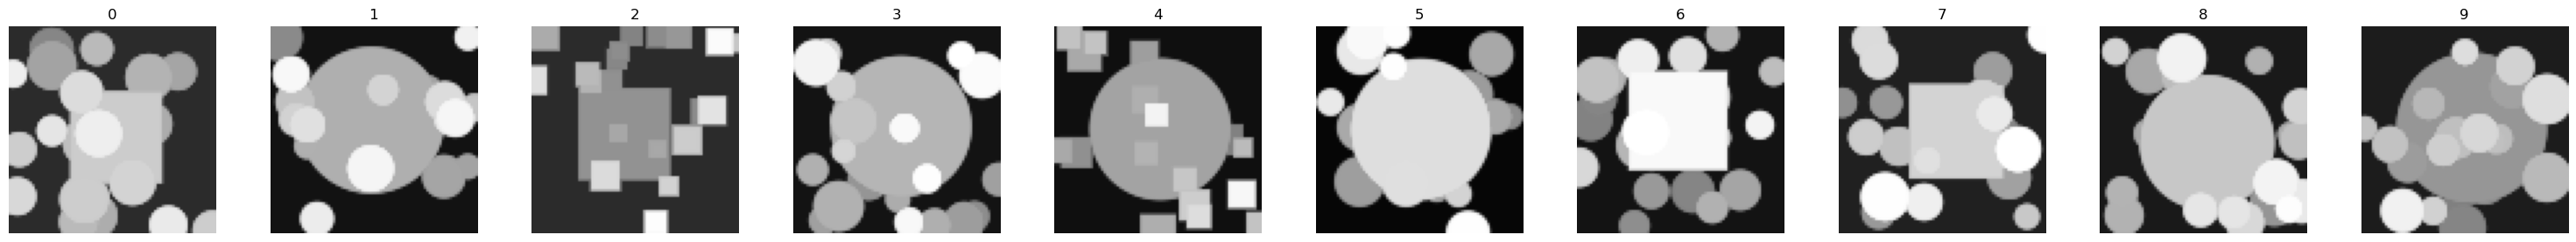

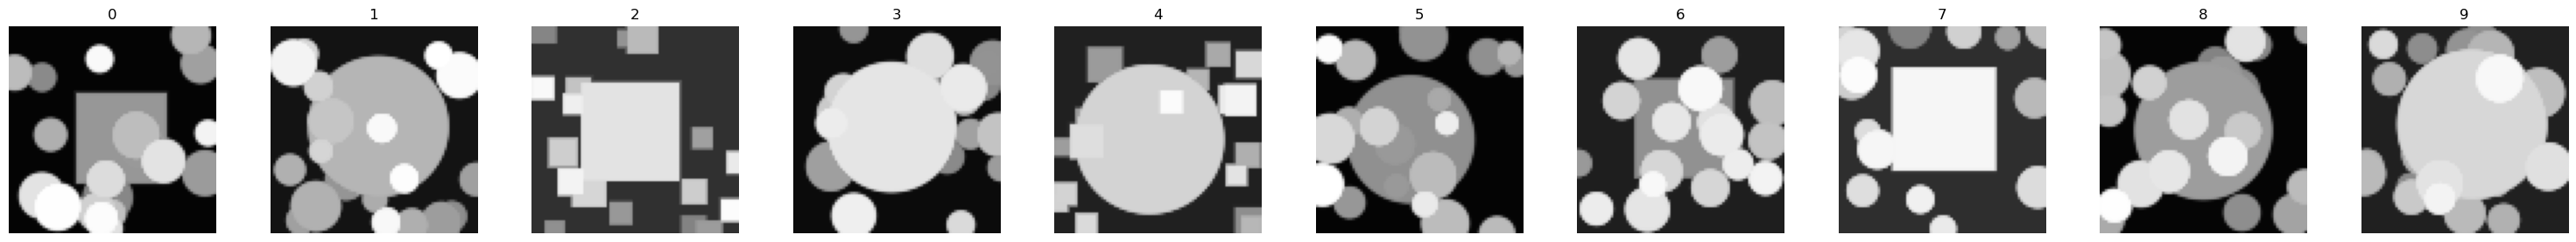

total number of train images: 1000


In [10]:
## shuffle train and test images and put them in one tensor 
loader, loader_cond = make_loader(dataset=train_sets, batch_size=512, dataset_cond=train_sets, self_cond =False, )    
train ={}
train['inp']  = loader.dataset
train['cond'] = loader_cond.dataset
show_im_set(train['inp'][0:10], n_columns=10, vmin=0, vmax = 1)
show_im_set(train['cond'][0:10], n_columns=10, vmin=0, vmax = 1)
print('total number of train images:',train['inp'].shape[0])


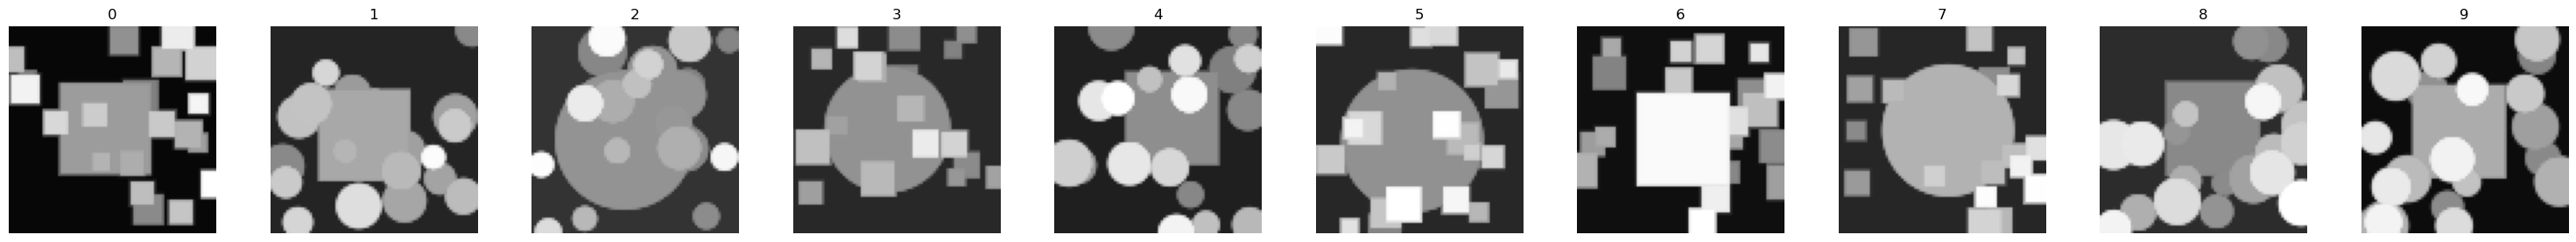

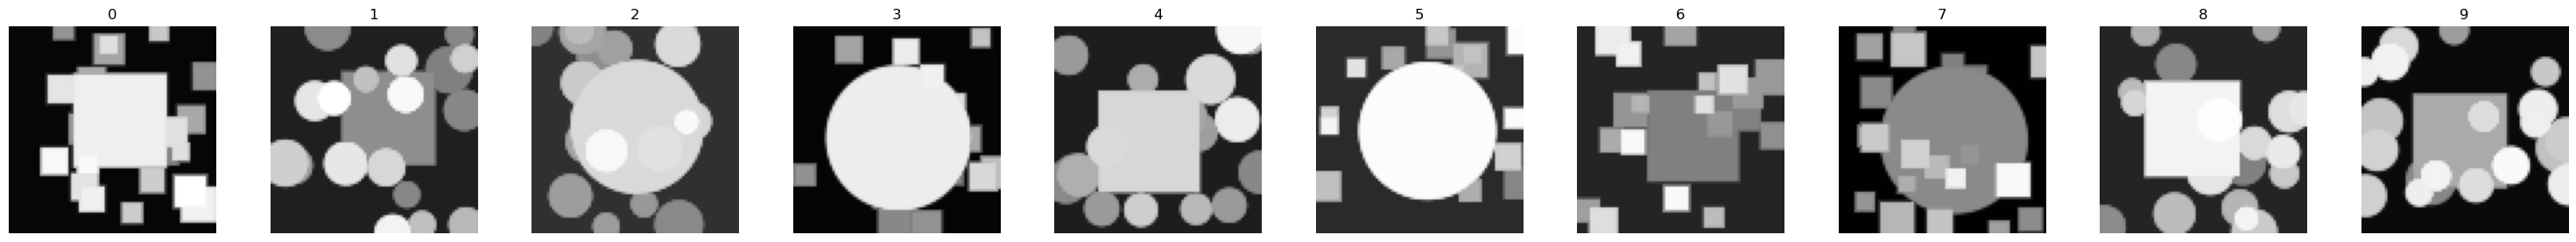

total number of test images: 1000


In [11]:
loader, loader_cond = make_loader(dataset=test_sets, batch_size=256, dataset_cond=test_sets, self_cond =False)        
test ={}
test['inp']  = loader.dataset[0:1024]
test['cond'] = loader_cond.dataset[0:1024]
show_im_set(test['inp'][0:10], n_columns=10, vmin=0, vmax = 1)
show_im_set(test['cond'][0:10], n_columns=10, vmin=0, vmax = 1)
print('total number of test images:',test['inp'].shape[0])


In [12]:
test['inp'].mean(dim=(1,2,3)).shape

torch.Size([1000])

tensor(0.4521)


80

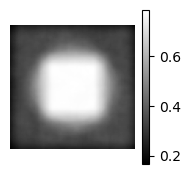

In [13]:
dist_mean = test['inp'].mean(0)
plot_single_im(dist_mean, colorbar=True)
print(dist_mean.mean())
K = dist_mean.shape[2]
K

# auxilary functions 

In [14]:

def get_channel_means(unet, x1, x2=None, average_phi=False, with_params=True, return_activations = False): 
    '''
    returns means of channels (phi) of a conditional or regular UNet
    if conditional unet: returns means of channels for either input or conditioner image, or both
    if unconditional unet: returns means of channels for input
    @noisy: of shape N,C,H,W
    @with_param: important: set to False if phi is computed to be given to the network (instead of x)
    '''    
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    # set network in saving mode
    unet.save_means = True    
    if return_activations: 
        unet.save_activations = True

    #compute the responses 
    with torch.no_grad():
        try: #for conditional model
            if x2 is None: #if only conditioner image is given 
                out = unet(x1.to(device), x1.to(device), average_phi)
            else: # if a noisy input is also given
                out = unet(x2.to(device), x1.to(device), average_phi)
                x_means = unet.stored_x_means
                
            x_c_means = unet.stored_x_c_means
            x_c = unet.stored_x_c
            
        except TypeError: # for the unconditional model
            out = unet(x1.to(device))
            x_c_means = unet.stored_x_c_means
            x_c = unet.stored_x_c
            if average_phi: 
                for i in range(len(x_c_means)): 
                    x_c_means[i] = x_c_means[i].mean(0,keepdim=True)
            
    
    unet.save_means = False
    unet.save_activations = False


    if with_params:   
        try:
            params = get_matching_params(unet)
            for i in range(len(params)): 
                x_c_means[i] = x_c_means[i] * params[i]
        except AttributeError: 
            pass

    if (x2 is None) & (return_activations is False): 
        return x_c_means
    elif (x2 is None) & (return_activations is True): 
        return x_c_means, x_c
    elif (x2 is not None) & (return_activations is False): 
        return x_c_means, x_means
    else: 
        return x_c_means, x_means, x_c

def get_matching_params(unet): 
    params = []
    for l in range(len(unet.encoder_matching_params)):
        params.append(unet.encoder_matching_params[str(l)].detach().to(device))
    params.append(unet.mid_matching_params.detach().to(device))
    for l in range(len(unet.decoder_matching_params)-1, 0,-1):
        params.append(unet.decoder_matching_params[str(l)].detach().to(device))
    return params

# Sparsity and correlation of $\phi$

## 1. $\phi$ is sparse in mixture and conditional models

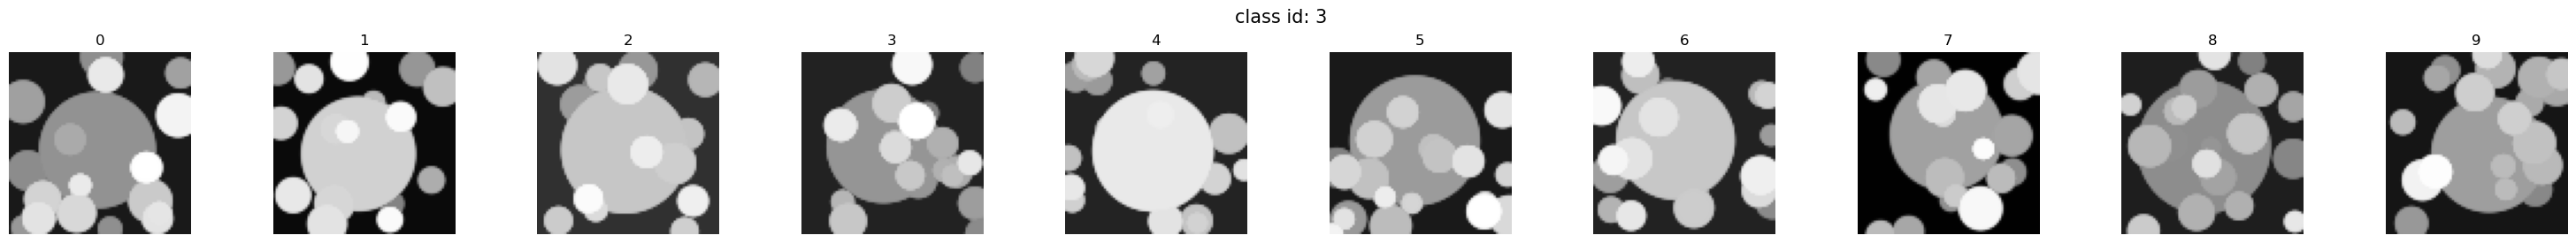

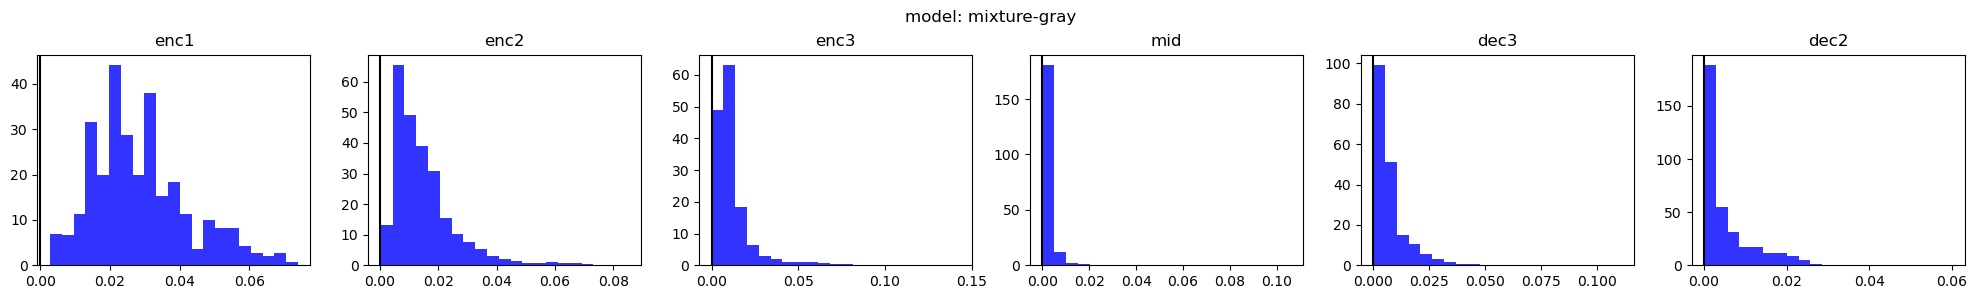

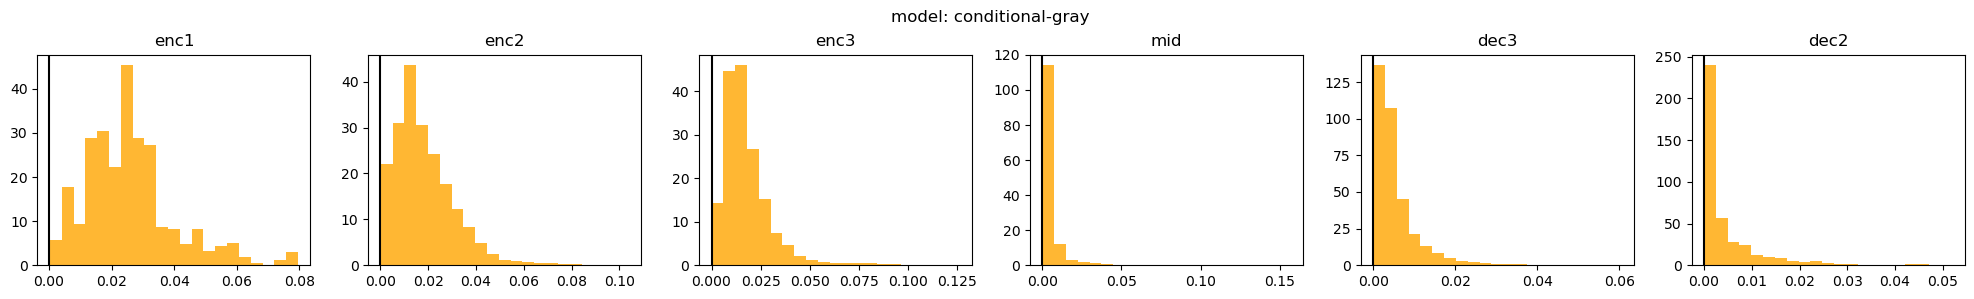

In [16]:
c = np.random.randint(0,len(train_sets), 1)[0]
im_cond = train_sets[c]
show_im_set(im_cond[0:10],  n_columns=10, label = 'class id: ' + str(c), vmin=0, vmax = 1)

sig = 200 #sigma used for mixture model input
colors = ['blue', 'orange']
for j,group in zip(range(2),['mixture-gray', 'conditional-gray']): 
    f , axs = plt.subplots(1,len(blocks), figsize=(20,3), sharex = False, sharey=False)
    f.suptitle('model: ' + group)    
    plt.tight_layout()    
    if 'gray' in group:
        im_cond = im_cond.mean(dim = 1, keepdim=True)
    if 'mixture' in group: 
        im_cond = add_noise_torch(im_cond, sig)[0]
    phi = get_channel_means(denoisers[group], im_cond ,average_phi=False, with_params=True)
        
    for i in range(len(blocks)): 
        axs[i].hist( (phi[i].flatten()).cpu().abs() , bins=21, density=True, label = group, alpha = .8, color = colors[j] )
        axs[i].set_title(blocks[i])
        axs[i].axvline(0, color='k')
        


## Pairwise class comparions: in deep layers $\phi$ are correlated for mixture model, but de-correlated for conditional model:

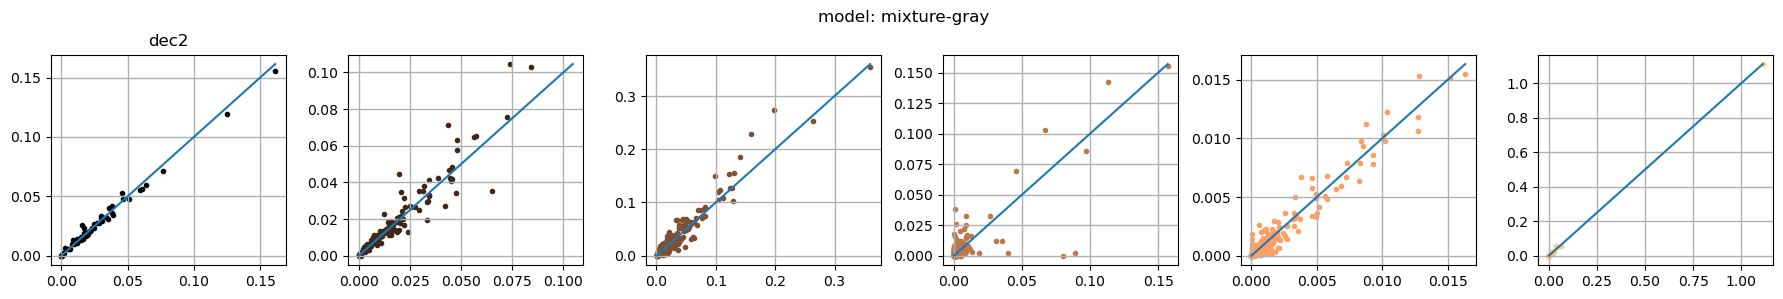

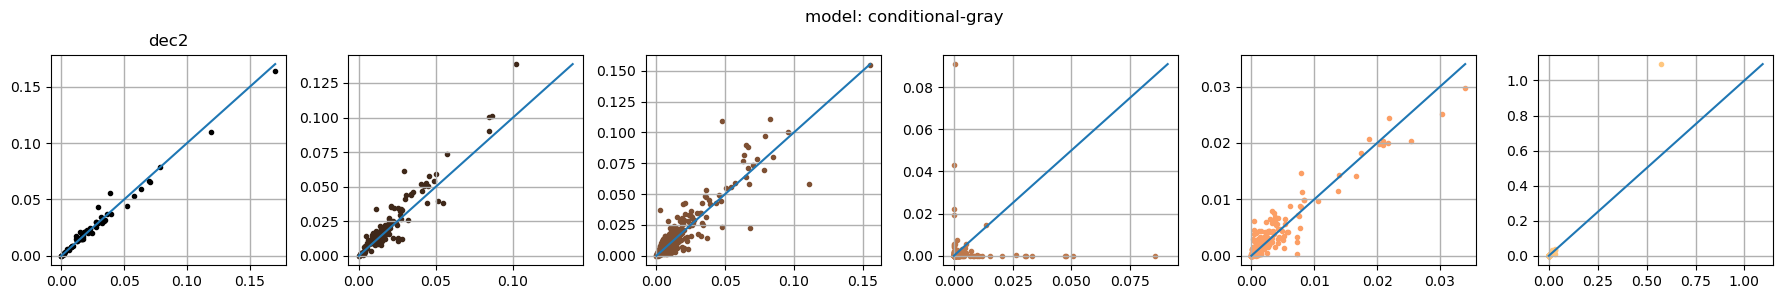

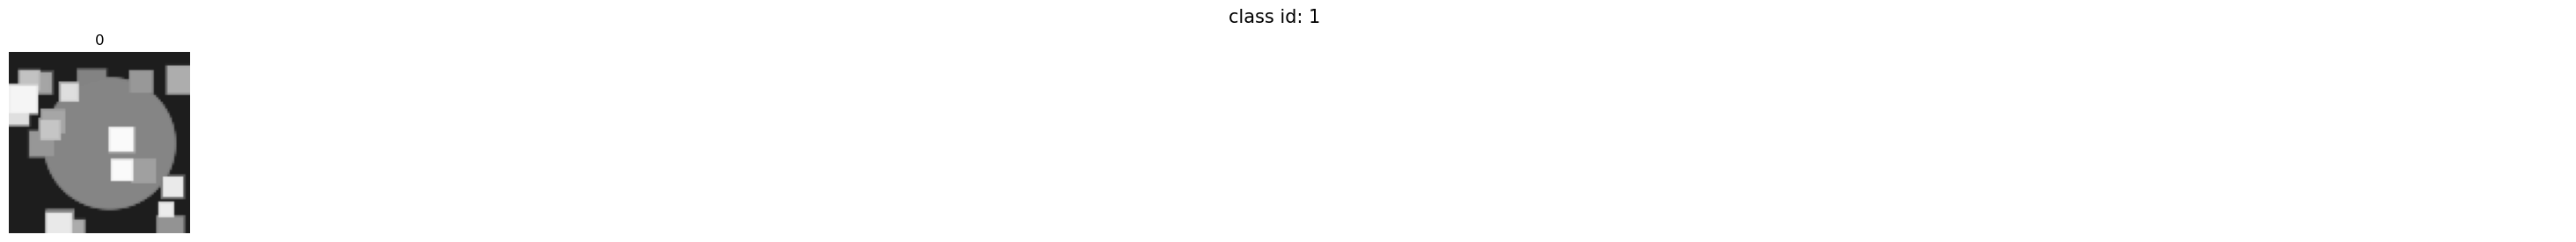

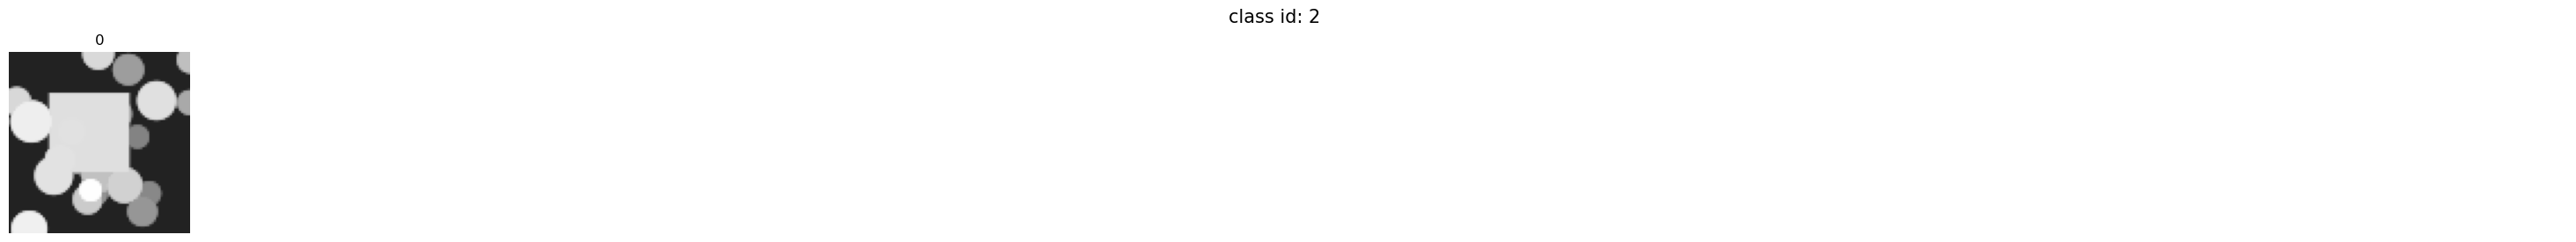

In [63]:
### compare two classes against each other ####
c1 = np.random.randint(0, len(train_sets), 1).item()
c2 = np.random.randint(0, len(train_sets), 1).item()

c1=1
c2=2
im1_cond = train_sets[c1][0:1]
im2_cond = train_sets[c2][0:1]


for group in ['mixture-gray', 'conditional-gray']:    
    if 'gray' in group: 
        im1_cond = im1_cond.mean(dim =1,keepdim=True )
        im2_cond = im2_cond.mean(dim =1, keepdim=True )
        
    phi_xc, x_c1 = get_channel_means(denoisers[group], im1_cond,average_phi=True,with_params=True , return_activations=True)
    phi_2, x_c2 = get_channel_means(denoisers[group], im2_cond ,average_phi=True, with_params=True , return_activations=True)
            
    f , axs = plt.subplots(1,len(blocks), figsize=(18,3), sharex = False, sharey=False)
    f.suptitle('model: ' + group)
    plt.tight_layout()
    axs = axs.ravel()
    colormap = plt.cm.copper #nipy_spectral, Set1,Paired   
    plot_colors = [colormap(i) for i in np.linspace(0, 1,len(blocks))]
    for i in range(len(blocks)): 
        axs[i].scatter( (phi_xc[i]).cpu().abs(), (phi_2[i]).cpu().abs(), marker ='.' , color=plot_colors[i])
    
        axs[0].set_title(blocks[i])
        axs[i].grid(  linewidth=1);
        axs[i].plot([min((phi_xc[i]).cpu().abs().min(), (phi_2[i]).cpu().abs().min()),max((phi_xc[i]).cpu().abs().max(), (phi_2[i]).cpu().abs().max())],
                    [min((phi_xc[i]).cpu().abs().min(), (phi_2[i]).cpu().abs().min()),max((phi_xc[i]).cpu().abs().max(), (phi_2[i]).cpu().abs().max())])

show_im_set(im1_cond[0:10],  n_columns=10, label = 'class id: ' + str(c1), vmin=0, vmax = 1)
show_im_set(im2_cond[0:10], n_columns=10,  label = 'class id: ' + str(c2),vmin=0, vmax = 1)


## visualization of non-zero channels

### conditional model: 

In [57]:
### for the conditional model 
group = 'conditional-gray'
phi_xc, x_c1 = get_channel_means(denoisers[group], im1_cond,average_phi=False,with_params=True , return_activations=True)
phi_2, x_c2 = get_channel_means(denoisers[group], im2_cond ,average_phi=False, with_params=True , return_activations=True)

block = 1
im_n = 0 # pick one image from the class
# get the top active phis
ids_1 = phi_xc[block][im_n:im_n+1].sort(dim = 1, descending =True)[1].flatten()[0:20].cpu().numpy()
ids_2 = phi_2[block][im_n:im_n+1].sort(dim = 1, descending =True)[1].flatten()[0:20].cpu().numpy()
print(ids_1)
print(ids_2)
  

[ 82  44  18  96  63 126  97  87  51  70  11  41   1  25 109  21   7  95
  39 121]
[ 82  18  44  96  36  51  87  25  63  70  21  11 120   8  35  71  95   6
   1 107]


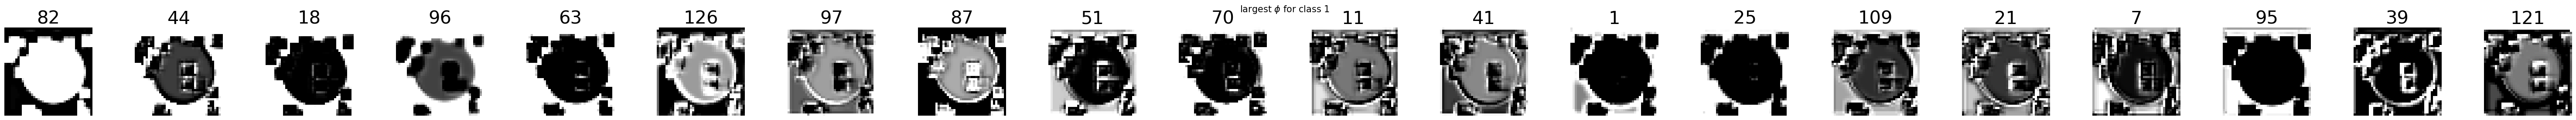

largest $\phi$ for class 1


In [58]:
show_im_set(x_c1[block][im_n].unsqueeze(1)[ids_1] , 
            sub_labels= ids_1,
            n_columns=20  , colorbar=False, vmin=0, vmax = phi_xc[block][im_n:im_n+1].max() , label='largest $\phi$ for class ' + str(c1) )
print('largest $\phi$ for class ' + str(c1) )

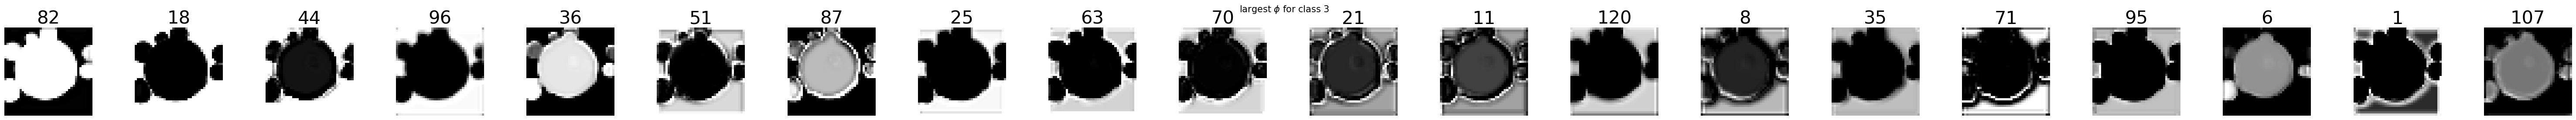

largest $\phi$ for class 3


In [59]:
show_im_set(x_c2[block][im_n].unsqueeze(1)[ids_2] , 
            sub_labels= ids_2,                        
            n_columns=20  , colorbar=False, vmin=0, vmax = phi_2[block][im_n:im_n+1].max() ,  label='largest $\phi$ for class ' + str(c2) ) 
print('largest $\phi$ for class ' + str(c2) )

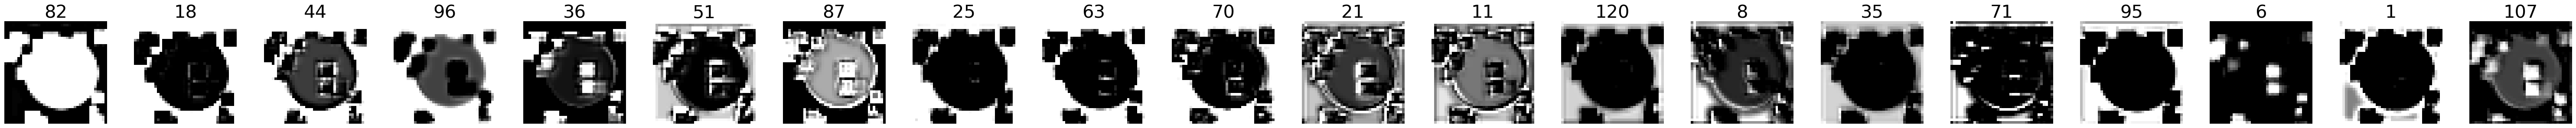

channels of image 1 for largert $\phi$ of image 3


In [60]:
show_im_set(x_c1[block][im_n].unsqueeze(1)[ids_2] , 
            sub_labels= ids_2,            
            n_columns=20  , colorbar=False, vmin=0, vmax = phi_xc[block][im_n:im_n+1].max() ) 
print('channels of image '+str(c1)+' for largert $\phi$ of image ' + str(c2) )

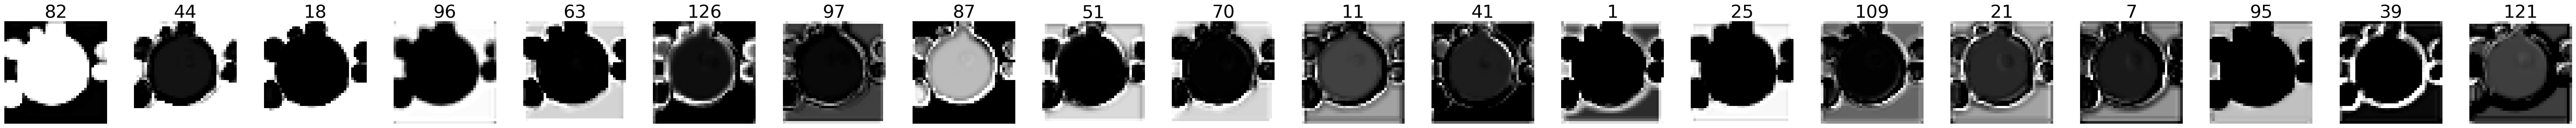

channels of image 3 for largert $\phi$ of image 1


In [61]:
show_im_set(x_c2[block][im_n].unsqueeze(1)[ids_1] , 
            sub_labels= ids_1,                        
            n_columns=20  , colorbar=False, vmin=0, vmax = phi_2[block][im_n:im_n+1].max() ) 
print('channels of image '+str(c2)+' for largert $\phi$ of image ' + str(c1) )

### mixture model: 

In [69]:
### for the mixture model 
group = 'mixture-gray'
sig = 100
phi_xc, x_c1 = get_channel_means(denoisers[group], 
                                x1=add_noise_torch(im1_cond,noise_level=sig)[0],
                                average_phi=False,with_params=True , return_activations=True)
phi_2, x_c2 = get_channel_means(denoisers[group], 
                                x1=add_noise_torch(im2_cond,noise_level=sig)[0],
                                average_phi=False, with_params=True , return_activations=True)
1block = 3
im_n = 0 # pick one image from the class
# get the top active phis
ids_1 = phi_xc[block][im_n:im_n+1].sort(dim = 1, descending =True)[1].flatten()[0:20].cpu().numpy()
ids_2 = phi_2[block][im_n:im_n+1].sort(dim = 1, descending =True)[1].flatten()[0:20].cpu().numpy()
print(ids_1)
print(ids_2)
  

SyntaxError: invalid syntax (3673568343.py, line 10)

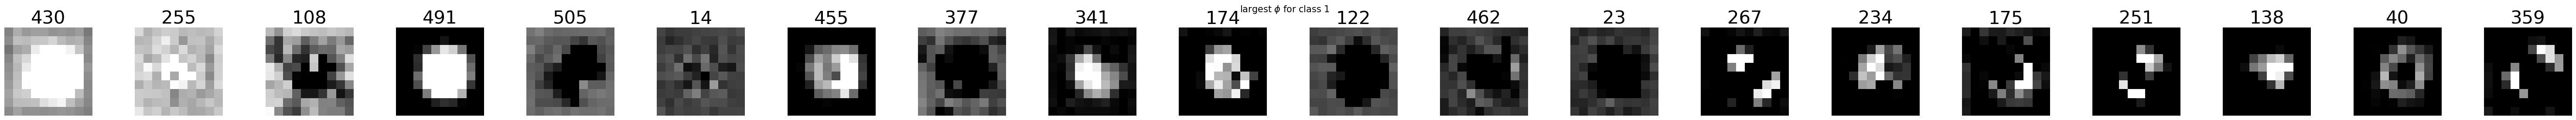

largest $\phi$ for class 1


In [65]:
show_im_set(x_c1[block][im_n].unsqueeze(1)[ids_1] , 
            sub_labels= ids_1,
            n_columns=20  , colorbar=False, vmin=0, vmax = phi_xc[block][im_n:im_n+1].max() , label='largest $\phi$ for class ' + str(c1) )
print('largest $\phi$ for class ' + str(c1) )

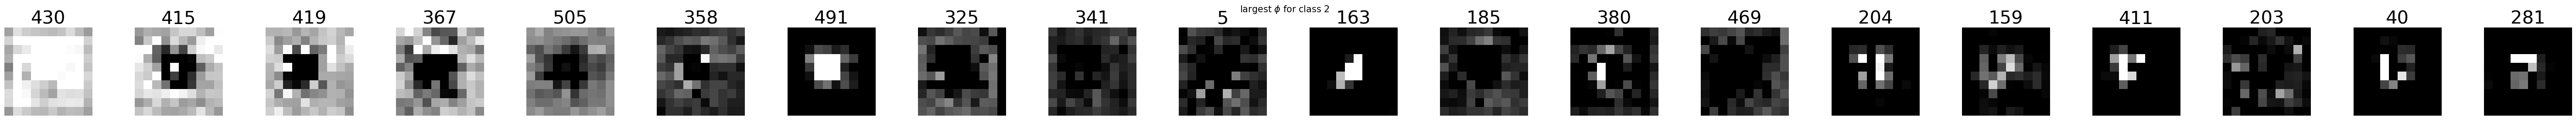

largest $\phi$ for class 2


In [66]:
show_im_set(x_c2[block][im_n].unsqueeze(1)[ids_2] , 
            sub_labels= ids_2,                        
            n_columns=20  , colorbar=False, vmin=0, vmax = phi_2[block][im_n:im_n+1].max() ,  label='largest $\phi$ for class ' + str(c2) ) 
print('largest $\phi$ for class ' + str(c2) )

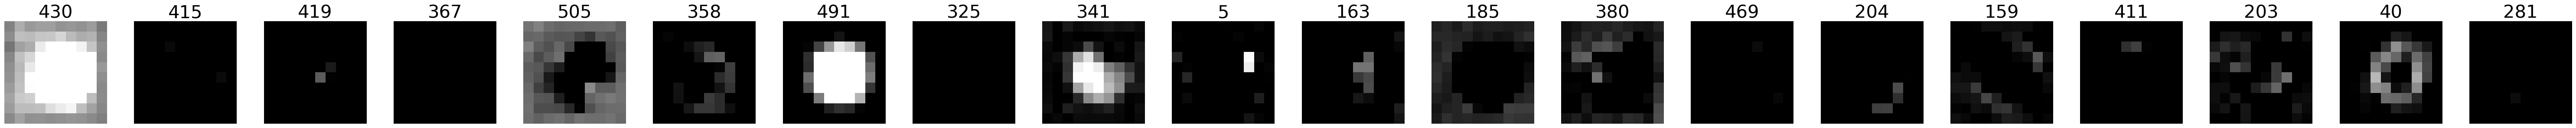

channels of image 1 for largert $\phi$ of image 2


In [67]:
show_im_set(x_c1[block][im_n].unsqueeze(1)[ids_2] , 
            sub_labels= ids_2,            
            n_columns=20  , colorbar=False, vmin=0, vmax = phi_xc[block][im_n:im_n+1].max() ) 
print('channels of image '+str(c1)+' for largert $\phi$ of image ' + str(c2) )

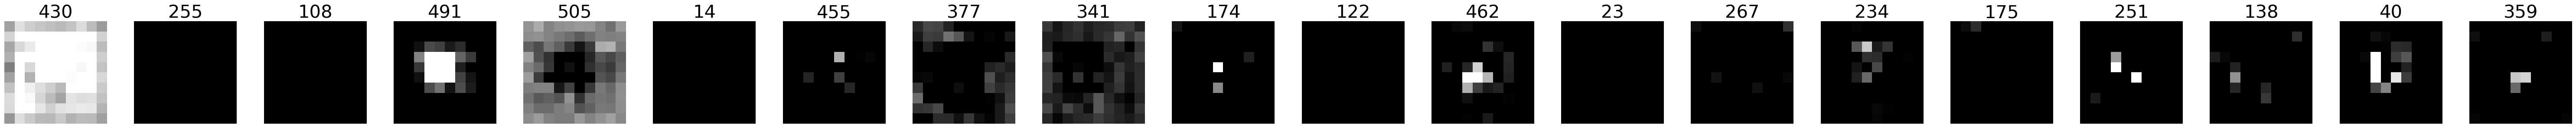

channels of image 2 for largert $\phi$ of image 1


In [68]:
show_im_set(x_c2[block][im_n].unsqueeze(1)[ids_1] , 
            sub_labels= ids_1,                        
            n_columns=20  , colorbar=False, vmin=0, vmax = phi_2[block][im_n:im_n+1].max() ) 
print('channels of image '+str(c2)+' for largert $\phi$ of image ' + str(c1) )

## 3. Sparsity of many classes: Soft measure of dimensionality
## Participation ratio 

${||\phi_c||_1^2}/{||\phi_c||_2^2} / N$

In [34]:
### compute phi's for a bunch of images from diffrent classes 

start_time_total = time.time()        

all_phi_x  = {}
all_phi_c = {}

for group in groups: 
    all_phi = []
    ### compute phi_x and phi_c for all classes 
    for c in range(0,len(train_sets) ):     
        if 'color' in group.split('-'):
            im_cond = train_sets[c]    
        else: 
            im_cond = train_sets[c].mean(dim = 1, keepdim = True)    
            
        phi, x_c = get_channel_means(denoisers[group], im_cond, average_phi=False, with_params=True, return_activations=True)
        
        all_phi.append(torch.hstack(phi).squeeze())
        if c%100 == 0:
            print('class id#:',c, "--- %s seconds ---" % (time.time() - start_time_total))
        
    all_phi_x[group] = torch.stack(all_phi).cpu()
    all_phi_c[group] = all_phi_x[group].mean(dim=1,keepdim=True)
    
    print(all_phi_x[group].shape)


class id#: 0 --- 0.00947117805480957 seconds ---
torch.Size([4, 250, 1344])
class id#: 0 --- 0.5331394672393799 seconds ---
torch.Size([4, 250, 1344])


--------- model:  mixture-gray
average participation ratio for $\phi(x)$ :  0.08092179149389267
--------- model:  conditional-gray
average participation ratio for $\phi(x)$ :  0.13822604715824127
--------- model:  mixture-gray
average participation ratio for $\phi_c$ :  0.08242977410554886
--------- model:  conditional-gray
average participation ratio for $\phi_c$ :  0.14117425680160522


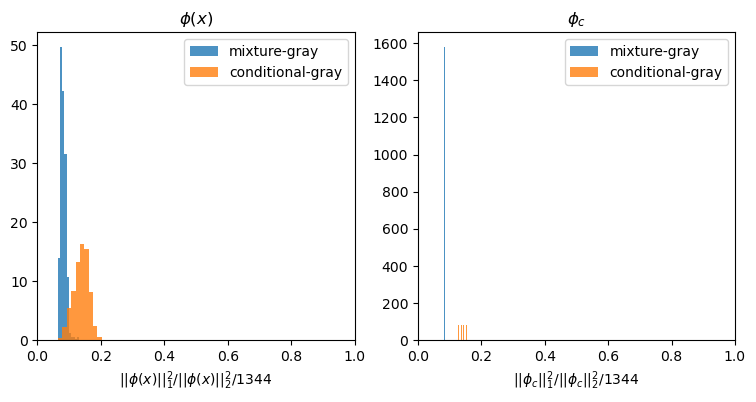

In [35]:
f, axs = plt.subplots(1,2, figsize = (9,4) )
for group in ['mixture-gray', 'conditional-gray']: 
    print('--------- model: ', group)
    participation_ratio = (all_phi_x[group].norm(1,dim = 2).squeeze()**2 /all_phi_x[group].norm(2,dim = 2, keepdim=True).squeeze()**2)/all_phi_x[group].shape[2]
    axs[0].hist(participation_ratio.flatten(), density=True, label = group, alpha = .8)
    print(r'average participation ratio for $\phi(x)$ : ', participation_ratio.mean().item())
    axs[0].set_xlim(0,1);
    axs[0].set_xlabel('$||\phi(x)||_1^2 / ||\phi(x)||_2^2 / 1344$');
    axs[0].set_title(r'$\phi(x)$')
    axs[0].legend();
for group in ['mixture-gray', 'conditional-gray']: 
    print('--------- model: ', group)
    participation_ratio = (all_phi_c[group].norm(1,dim = 2).squeeze()**2 /all_phi_c[group].norm(2,dim = 2, keepdim=True).squeeze()**2)/all_phi_c[group].shape[2]
    axs[1].hist(participation_ratio.flatten(), density=True, label = group, alpha = .8)
    print(r'average participation ratio for $\phi_c$ : ', participation_ratio.mean().item())
    axs[1].set_xlim(0,1);
    axs[1].set_xlabel('$||\phi_c||_1^2 / ||\phi_c||_2^2 / 1344$');
    axs[1].set_title(r'$\phi_c$')
    axs[1].legend();    

In [36]:
all_phi_x['mixture-gray'].shape

torch.Size([4, 250, 1344])

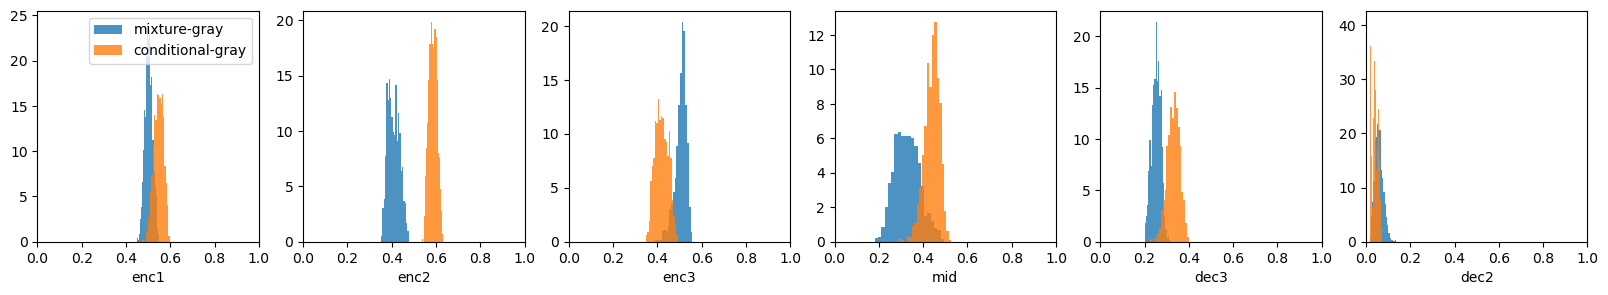

In [37]:
# participatino ratio per block 

f, axs = plt.subplots(1,len(blocks), figsize = (20,3) )

for  group in['mixture-gray', 'conditional-gray']: 
    k1 = 0
    
    for i, l in zip(range(len(blocks)), [16, 32,64,128, 256, 128, 64, 32]): 
        participation_ratio = (all_phi_x[group][:,:,k1:k1 + l].norm(1,dim = 2).squeeze()**2 /all_phi_x[group][:,:,k1:k1 + l].norm(2,dim = 2, keepdim=True).squeeze()**2 ) /l
        axs[i].hist(participation_ratio.flatten(), bins = 21, alpha = .8, density=True, label = group)
        axs[i].set_xlim(0,1);
        axs[i].set_xlabel(blocks[i]  )
        axs[0].legend()
        k1 += l 



## 4. correlation of $\phi$ across many classes 

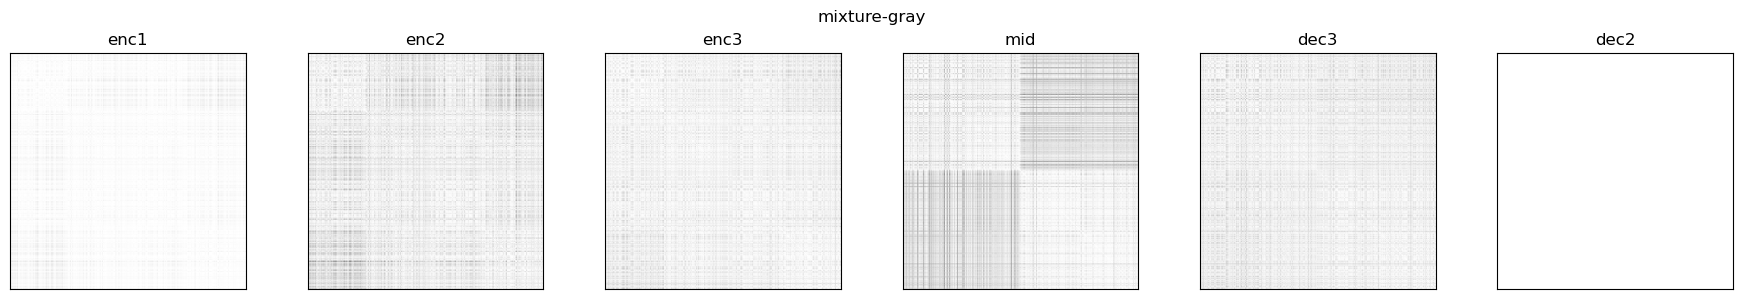

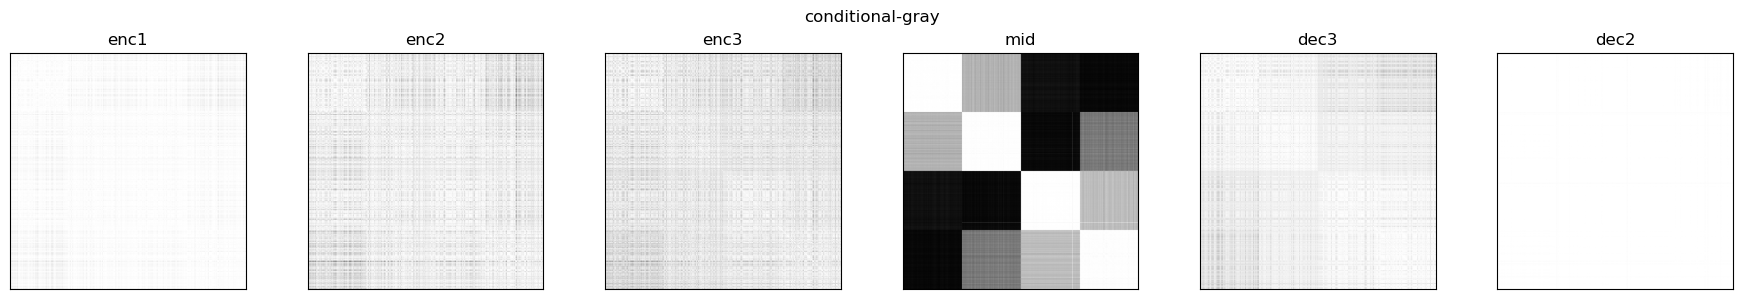

In [38]:
### average response per channel for different images from different classes (instead of pairwise response, we look at responses of many more classes )
ids = [0,1,2,3]
im1_cond = torch.cat([train_sets[category][0:100] for category in ids ])

for group in ['mixture-gray','conditional-gray' ]:
    if 'gray' in group.split('-'): 
        im1_cond = im1_cond.mean(dim = 1, keepdim = True)
    phi_xc = get_channel_means(denoisers[group], im1_cond,average_phi=False,with_params=True , return_activations=False)
        
    f, axs = plt.subplots(1, len(blocks), figsize = (18,3))
    plt.suptitle(group)
    for block in range(len(blocks)): 
        axs[block].imshow(torch.abs(torch.corrcoef(phi_xc[block].squeeze() )).cpu() , 'gray',vmin=0, vmax = 1)
        axs[block].tick_params(bottom=False,top = False, right = False, left=False)
        axs[block].set_xticks([])  
        axs[block].set_yticks([])      
        axs[block].set_title(blocks[block])
    plt.tight_layout()


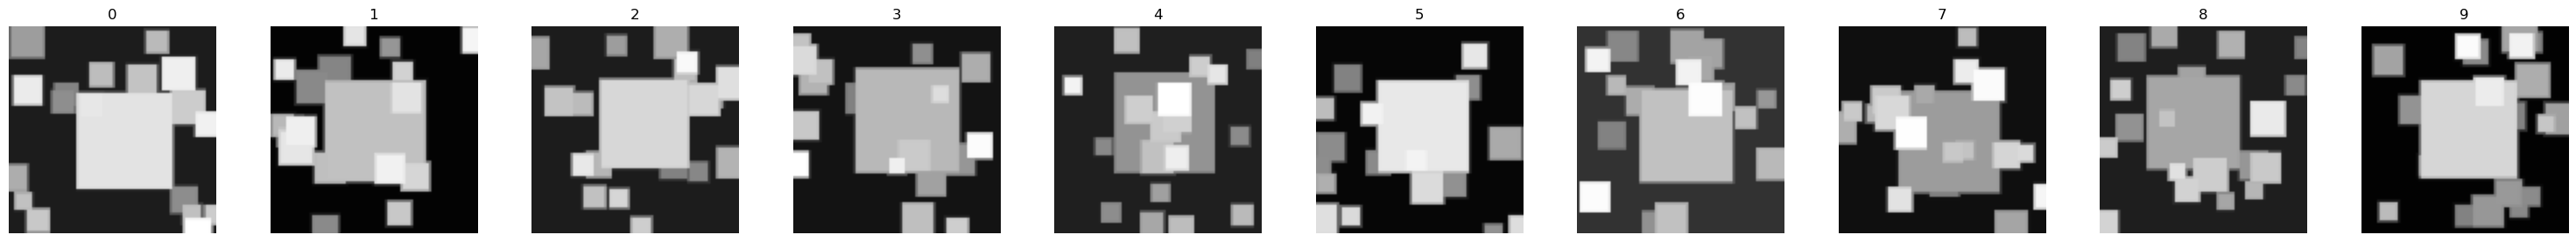

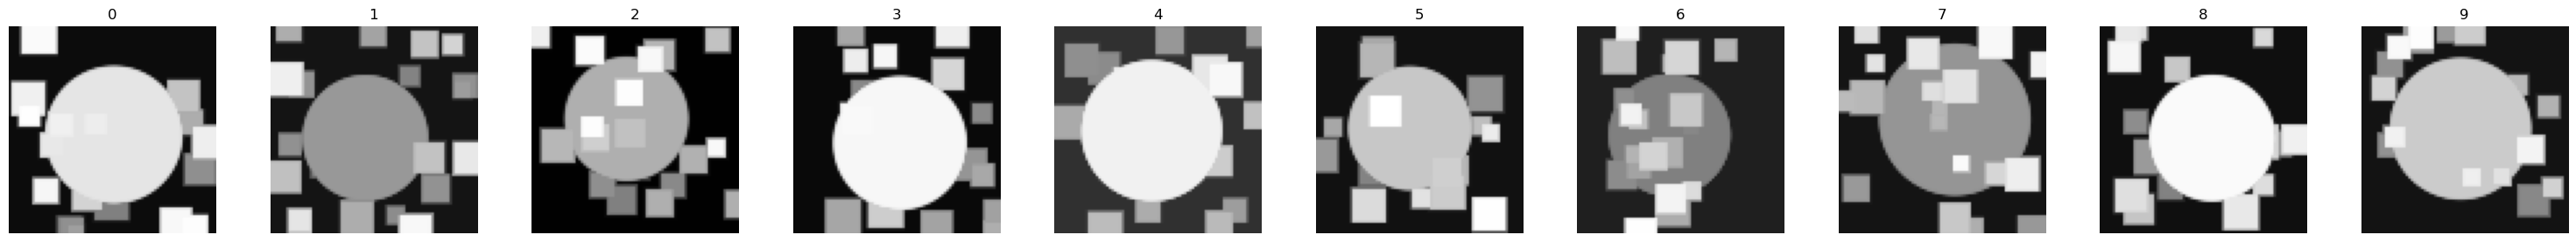

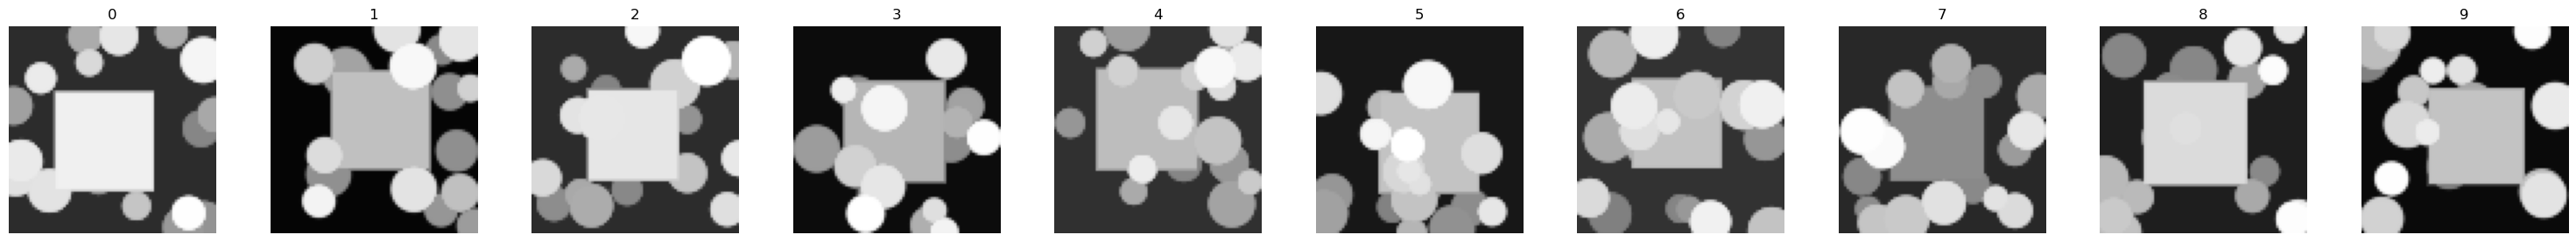

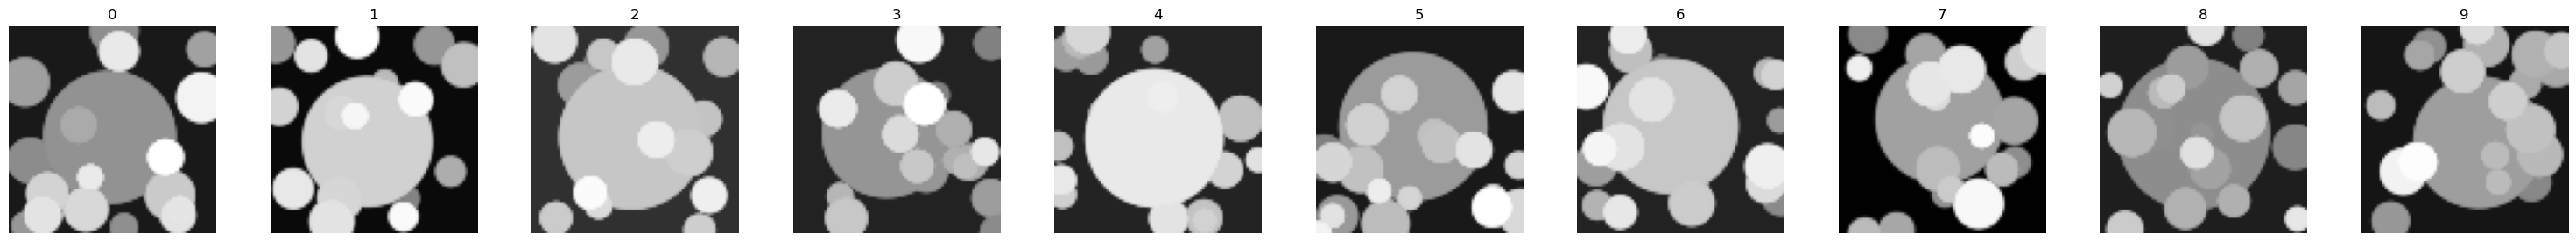

In [39]:
for i in ids:
    show_im_set(train_sets[i][0:10].mean(dim=1, keepdim= True), n_columns=10, vmin=0, vmax = 1)


# Connection between noisy $\phi$ and clean $\phi$

### change in sparsity of $\phi$ as a function of noise

In [40]:
group = 'mixture-gray'

start_time_total = time.time()        

all_phi_x  = {}
all_phi_c = {}

for sig in [0,30,100,200,250]: 
    all_phi = []
    ### compute phi_x and phi_c for all classes 
    for c in range(0,len(train_sets) ):     
        if 'color' in group.split('-'):
            im_cond = train_sets[c]    
        else: 
            im_cond = train_sets[c].mean(dim = 1, keepdim = True)    
            
        phi, x_c = get_channel_means(denoisers[group], 
                                     add_noise_torch(im_cond.to(device), sig, device=device)[0], 
                                      average_phi=False, with_params=True, return_activations=True)
        
        all_phi.append(torch.hstack(phi).squeeze())
        if c%100 == 0:
            print('class id#:',c, "--- %s seconds ---" % (time.time() - start_time_total))
        
    all_phi_x[sig] = torch.stack(all_phi).cpu()
    all_phi_c[sig] = all_phi_x[sig].mean(dim=1,keepdim=True)
    
    print(all_phi_x[sig].shape)


class id#: 0 --- 0.007944107055664062 seconds ---
torch.Size([4, 250, 1344])
class id#: 0 --- 0.520989179611206 seconds ---
torch.Size([4, 250, 1344])
class id#: 0 --- 1.0154809951782227 seconds ---
torch.Size([4, 250, 1344])
class id#: 0 --- 1.511627435684204 seconds ---
torch.Size([4, 250, 1344])
class id#: 0 --- 2.008063793182373 seconds ---
torch.Size([4, 250, 1344])


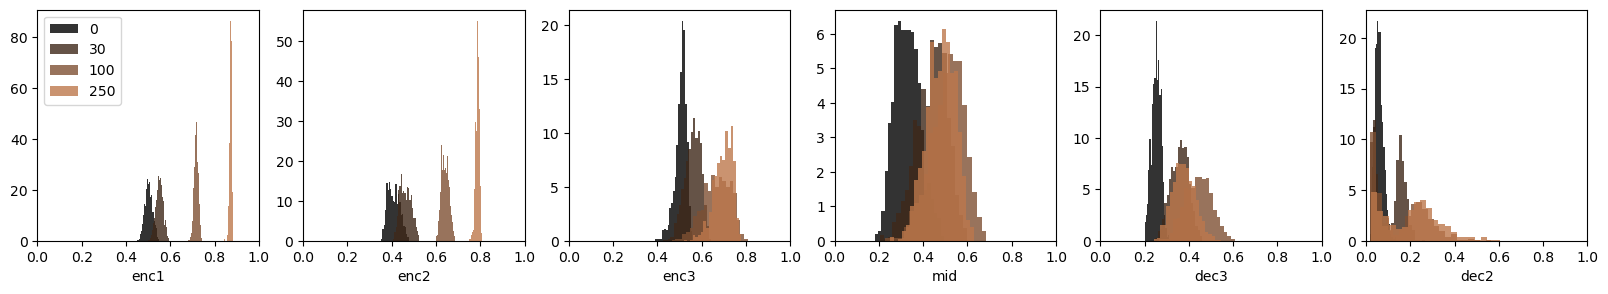

In [41]:
# participatino ratio per block 
colormap = plt.cm.copper #nipy_spectral, Set1,Paired   
plot_colors = [colormap(ii) for ii in np.linspace(0, 1, len(blocks))]

f, axs = plt.subplots(1,len(blocks), figsize = (20,3) )

for  j,sig in  zip( range(len(plot_colors)),[0,30,100,250]): 
    
    k1 = 0
    
    for i, l in zip(range(len(plot_colors)), [16, 32,64,128, 256, 128, 64, 32]): 
        # print(k1, k1 + l)
        participation_ratio = (all_phi_x[sig][:,:,k1:k1 + l].norm(1,dim = 2).squeeze()**2 /all_phi_x[sig][:,:,k1:k1 + l].norm(2,dim = 2, keepdim=True).squeeze()**2 ) /l
        axs[i].hist(participation_ratio.flatten(), bins = 21, alpha = .8, density=True, label = sig, color=plot_colors[j])
        axs[i].set_xlim(0,1);
        axs[i].set_xlabel(blocks[i]  )
        axs[0].legend()
        k1 += l 


     

### change in pairwise correlations as a function of noise

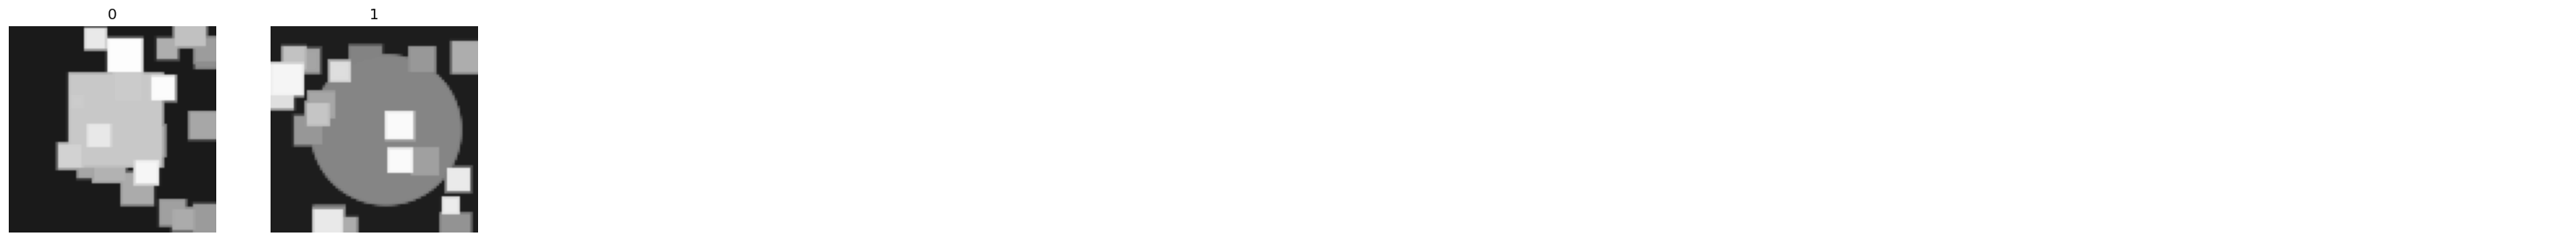

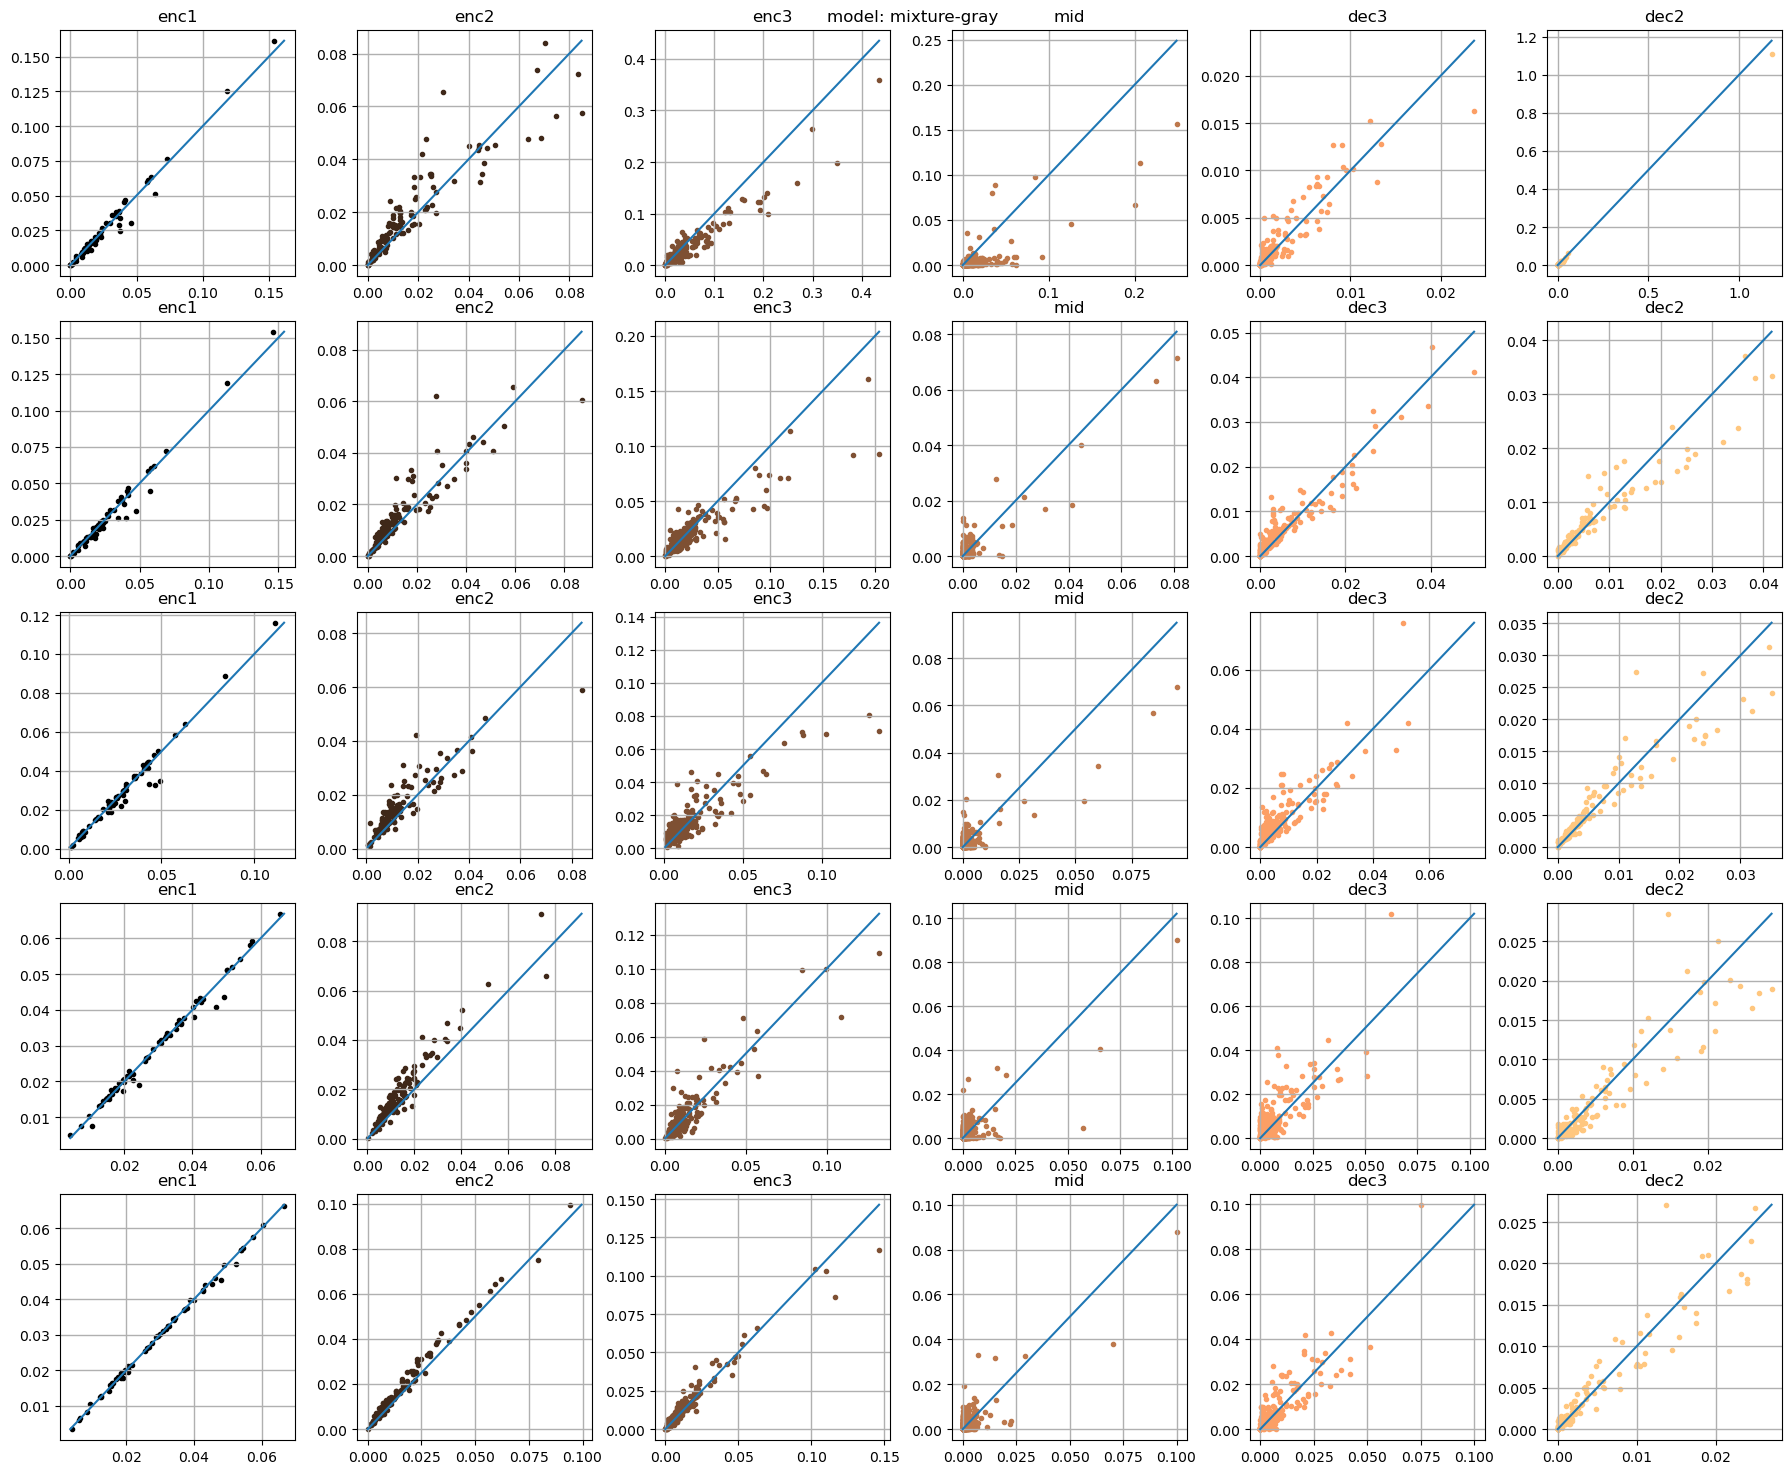

In [32]:
### compare two classes against each other ####
c1 = 0
c2 = 1
group = 'mixture-gray'

if 'color'  in group.split('-'):  
    show_im_set(torch.vstack((train_sets[c1][0:1], train_sets[c2][0:1] ) ),  n_columns=10, vmin=0, vmax = 1)
else: 
    show_im_set(torch.vstack((train_sets[c1][0:1].mean(dim = 1, keepdim = True), train_sets[c2][0:1].mean(dim = 1, keepdim = True) ) ),  n_columns=10, vmin=0, vmax = 1)
    



sigmas = [0,30,100,250,350]
f , axs = plt.subplots(len(sigmas),len(blocks), figsize=(18,3 * len(sigmas)), sharex =False, sharey=False)
f.suptitle('model: ' + group)
plt.tight_layout()
colormap = plt.cm.copper #nipy_spectral, Set1,Paired   
plot_colors = [colormap(i) for i in np.linspace(0, 1,len(blocks))]

for  j,sig in  zip(range(len(sigmas)),sigmas): 

    
    if 'gray' in group.split('-'):  
        im1_cond = add_noise_torch(train_sets[c1][0:1].to(device), sig, device=device)[0].mean(dim = 1, keepdim = True)
        im2_cond = add_noise_torch(train_sets[c2][0:1].to(device), sig, device=device)[0].mean(dim = 1, keepdim = True)
    else: 
        im1_cond = add_noise_torch(train_sets[c1][0:1].to(device), sig, device=device)[0]
        im2_cond = add_noise_torch(train_sets[c2][0:1].to(device), sig, device=device)[0]



    phi_xc, x_c1 = get_channel_means(denoisers[group], im1_cond,average_phi=False,with_params=True , return_activations=True)
    phi_2, x_c2 = get_channel_means(denoisers[group], im2_cond ,average_phi=False, with_params=True , return_activations=True)
            


    for i in range( len(blocks) ): 
        axs[j,i].scatter( (phi_xc[i]).cpu().abs(), (phi_2[i]).cpu().abs(), marker ='.' , color=plot_colors[i])
    
        axs[j,i].set_title(blocks[i])
        axs[j,i].grid(  linewidth=1);
        axs[j,i].plot([min((phi_xc[i]).cpu().abs().min(), (phi_2[i]).cpu().abs().min()),max((phi_xc[i]).cpu().abs().max(), (phi_2[i]).cpu().abs().max())],
                    [min((phi_xc[i]).cpu().abs().min(), (phi_2[i]).cpu().abs().min()),max((phi_xc[i]).cpu().abs().max(), (phi_2[i]).cpu().abs().max())])
    


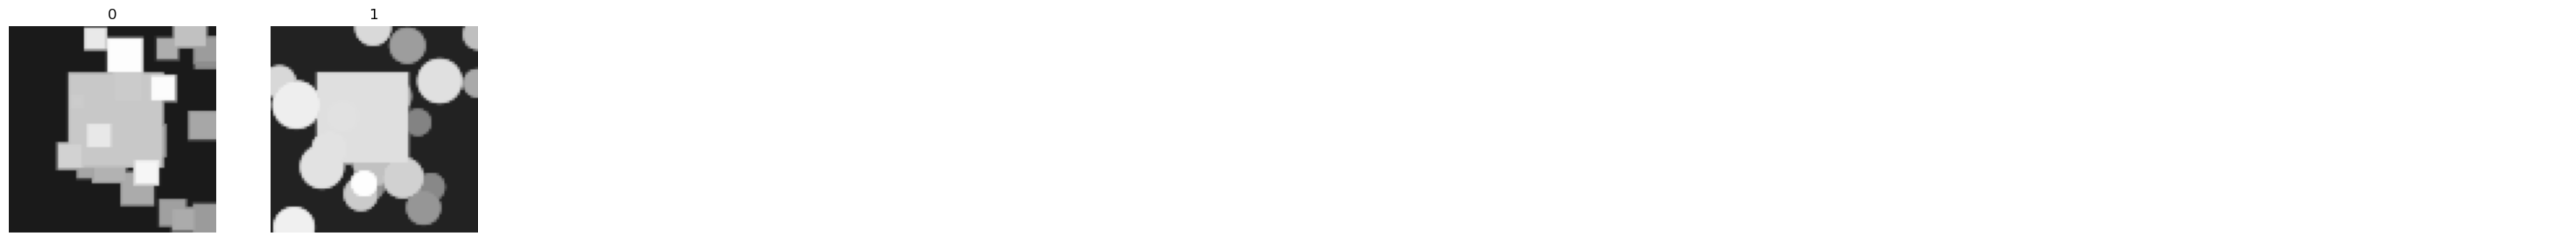

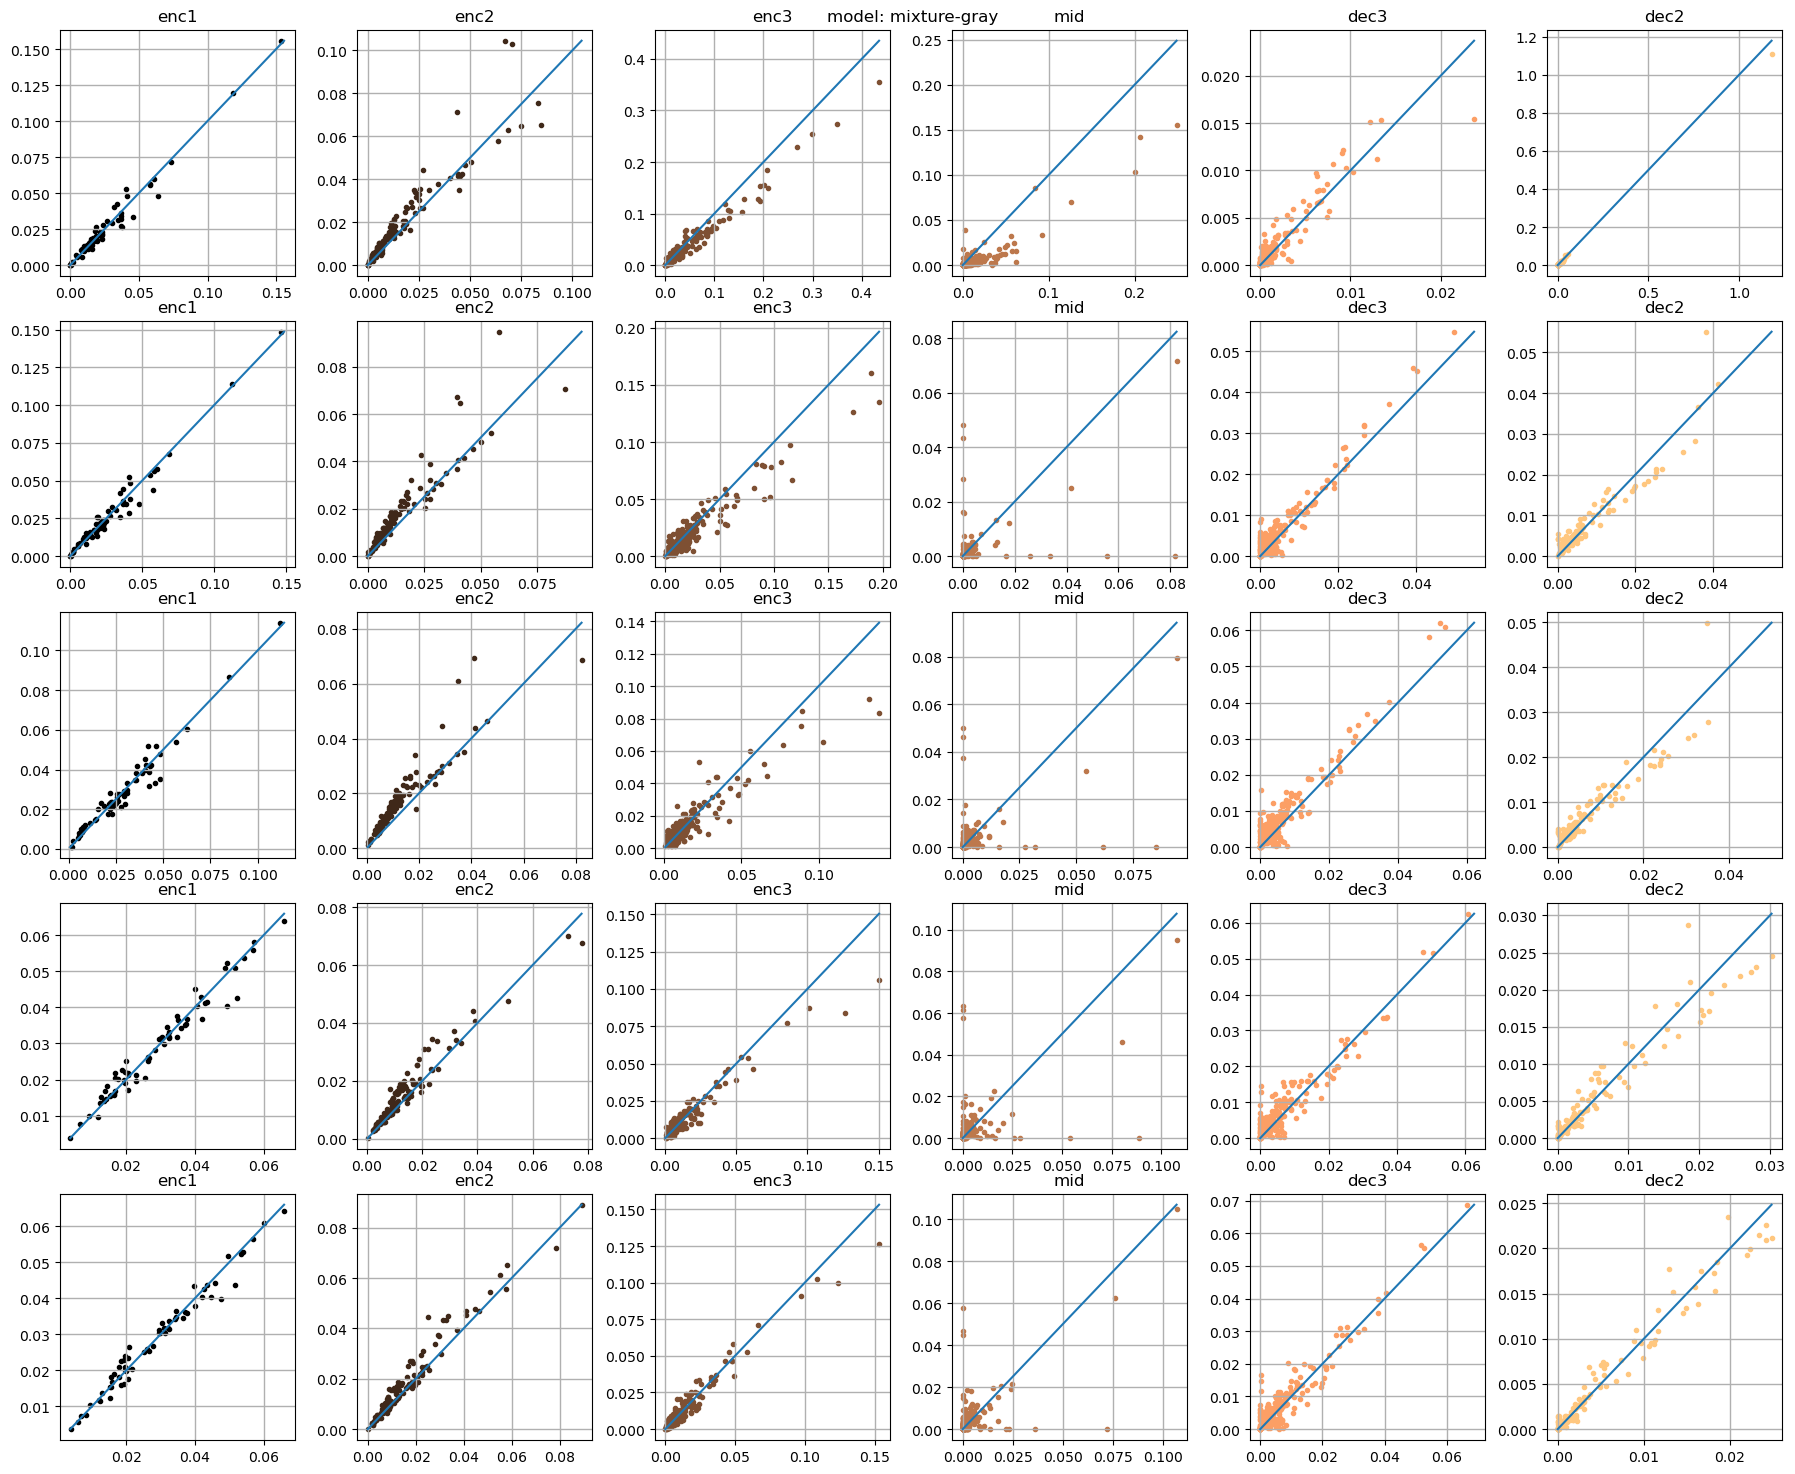

In [35]:
### compare two classes against each other ####
c1 = 0
c2 = 2
group = 'mixture-gray'

if 'color'  in group.split('-'):  
    show_im_set(torch.vstack((train_sets[c1][0:1], train_sets[c2][0:1] ) ),  n_columns=10, vmin=0, vmax = 1)
else: 
    show_im_set(torch.vstack((train_sets[c1][0:1].mean(dim = 1, keepdim = True), train_sets[c2][0:1].mean(dim = 1, keepdim = True) ) ),  n_columns=10, vmin=0, vmax = 1)
    



sigmas = [0,30,100,250,350]
f , axs = plt.subplots(len(sigmas),len(blocks), figsize=(18,3 * len(sigmas)), sharex =False, sharey=False)
f.suptitle('model: ' + group)
plt.tight_layout()
colormap = plt.cm.copper #nipy_spectral, Set1,Paired   
plot_colors = [colormap(i) for i in np.linspace(0, 1,len(blocks))]

for  j,sig in  zip(range(len(sigmas)),sigmas): 

    
    if 'gray' in group.split('-'):  
        im1_cond = add_noise_torch(train_sets[c1][0:1].to(device), sig, device=device)[0].mean(dim = 1, keepdim = True)
        im2_cond = add_noise_torch(train_sets[c2][0:1].to(device), sig, device=device)[0].mean(dim = 1, keepdim = True)
    else: 
        im1_cond = add_noise_torch(train_sets[c1][0:1].to(device), sig, device=device)[0]
        im2_cond = add_noise_torch(train_sets[c2][0:1].to(device), sig, device=device)[0]



    phi_xc, x_c1 = get_channel_means(denoisers[group], im1_cond,average_phi=False,with_params=True , return_activations=True)
    phi_2, x_c2 = get_channel_means(denoisers[group], im2_cond ,average_phi=False, with_params=True , return_activations=True)
            


    for i in range( len(blocks) ): 
        axs[j,i].scatter( (phi_xc[i]).cpu().abs(), (phi_2[i]).cpu().abs(), marker ='.' , color=plot_colors[i])
    
        axs[j,i].set_title(blocks[i])
        axs[j,i].grid(  linewidth=1);
        axs[j,i].plot([min((phi_xc[i]).cpu().abs().min(), (phi_2[i]).cpu().abs().min()),max((phi_xc[i]).cpu().abs().max(), (phi_2[i]).cpu().abs().max())],
                    [min((phi_xc[i]).cpu().abs().min(), (phi_2[i]).cpu().abs().min()),max((phi_xc[i]).cpu().abs().max(), (phi_2[i]).cpu().abs().max())])
    


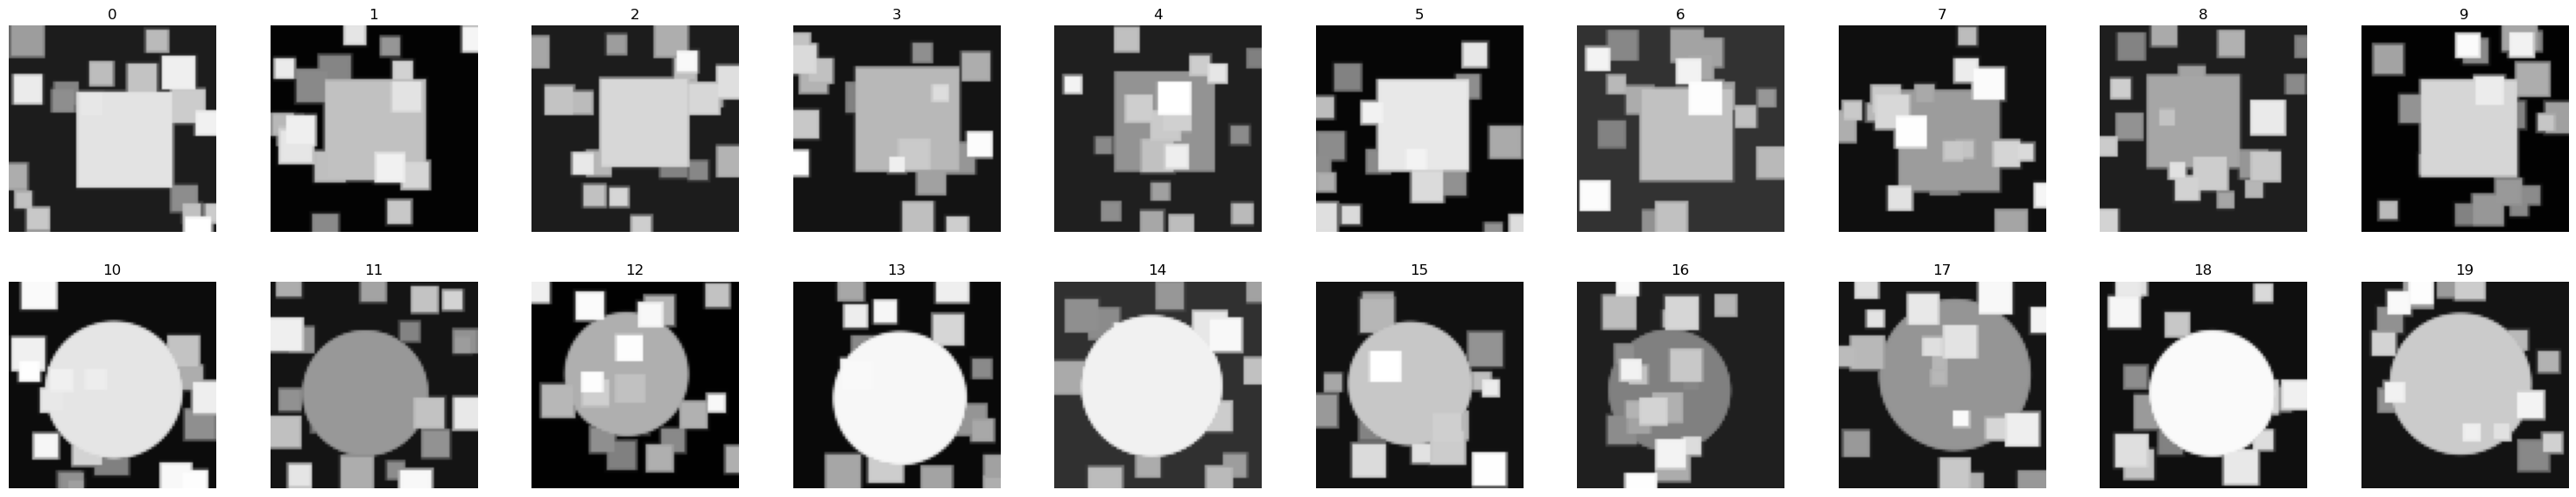

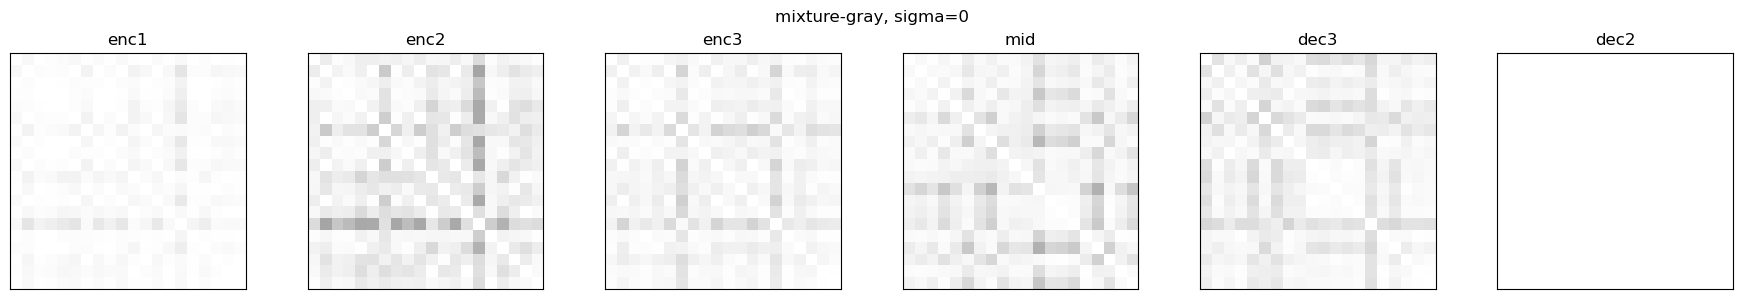

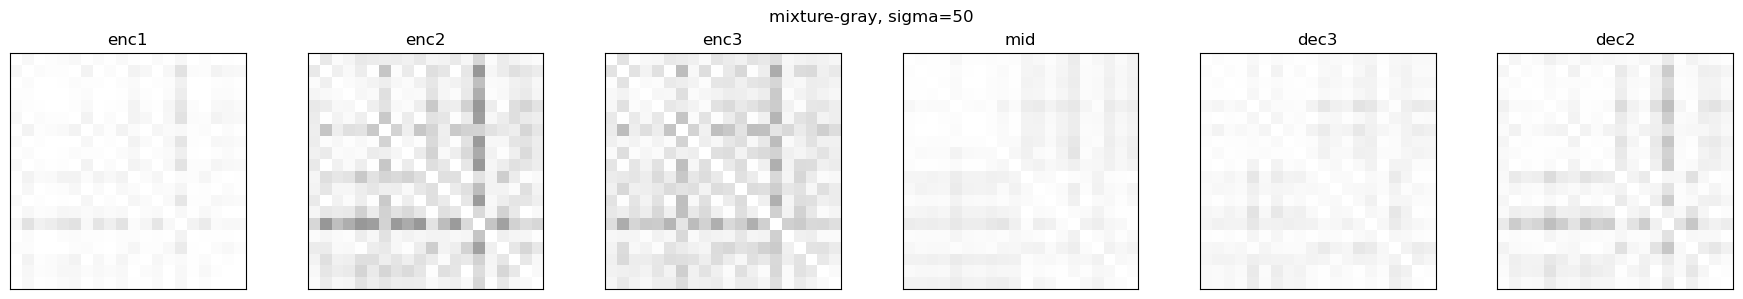

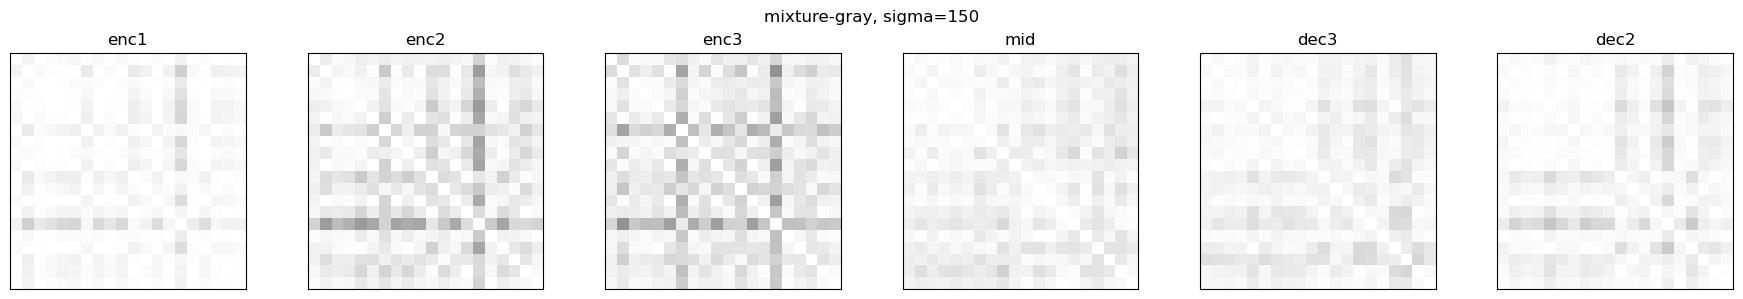

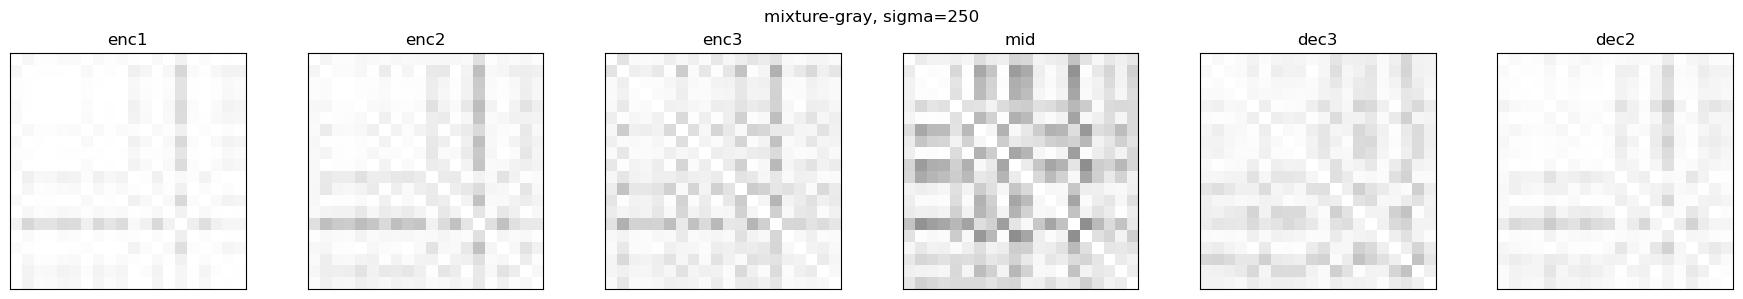

In [51]:
### average response per channel for different images from different classes (instead of pairwise response, we look at responses of many more classes )
ids = [0,1]

inp_ims = torch.cat([train_sets[category][0:10] for category in ids ])
if 'gray' in group.split('-'): 
    show_im_set(torch.vstack((train_sets[ids[0]][0:10], train_sets[ids[1]][0:10] ) ).mean(dim = 1, keepdim = True),  n_columns=10, vmin=0, vmax = 1)
else: 
    show_im_set(torch.vstack((train_sets[ids[0]][0:10], train_sets[ids[1]][0:10] ) ),  n_columns=10, vmin=0, vmax = 1)
    
# inp_ims = train['inp'][0:200]
# inp_ims = train_sets[1]


group = 'mixture-gray'
if 'gray' in group.split('-'): 
    inp_ims = inp_ims.mean(dim = 1, keepdim = True)
sigmas= [0, 50,150,250]
for sig in sigmas: 
    noisy_inp_ims = add_noise_torch(inp_ims.to(device), sig, device=device)[0]
    phi_xc = get_channel_means(denoisers[group], x1=noisy_inp_ims, x2=None,
                              average_phi=False,with_params=True , return_activations=False)
        
    f, axs = plt.subplots(1, len(blocks), figsize = (18,3))
    plt.suptitle(group+ ', sigma='+str(sig))
    for block in range(len(blocks)): 
        axs[block].imshow(torch.abs(torch.corrcoef(phi_xc[block].squeeze() )).cpu() , 'gray',vmin=0, vmax = 1)
        axs[block].tick_params(bottom=False,top = False, right = False, left=False)
        axs[block].set_xticks([])  
        axs[block].set_yticks([])      
        axs[block].set_title(blocks[block] )
    plt.tight_layout()



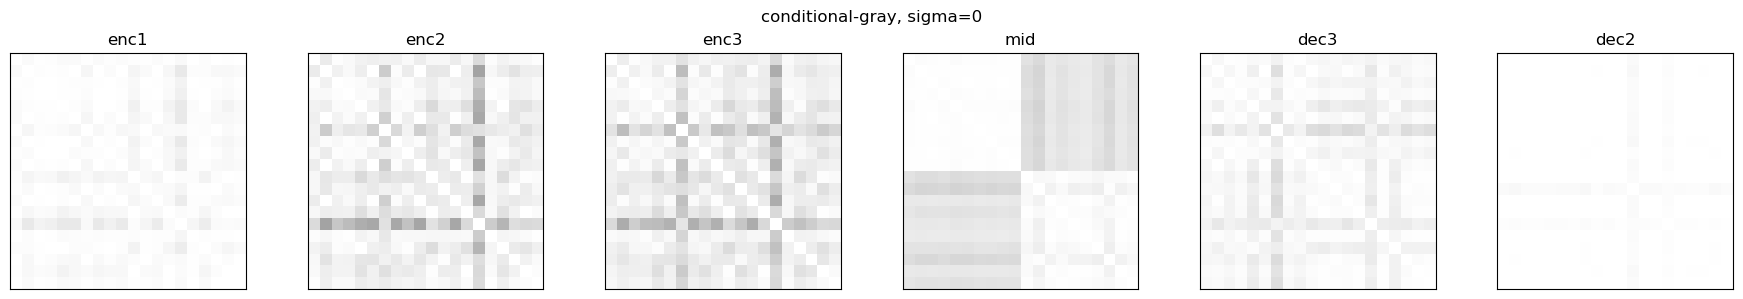

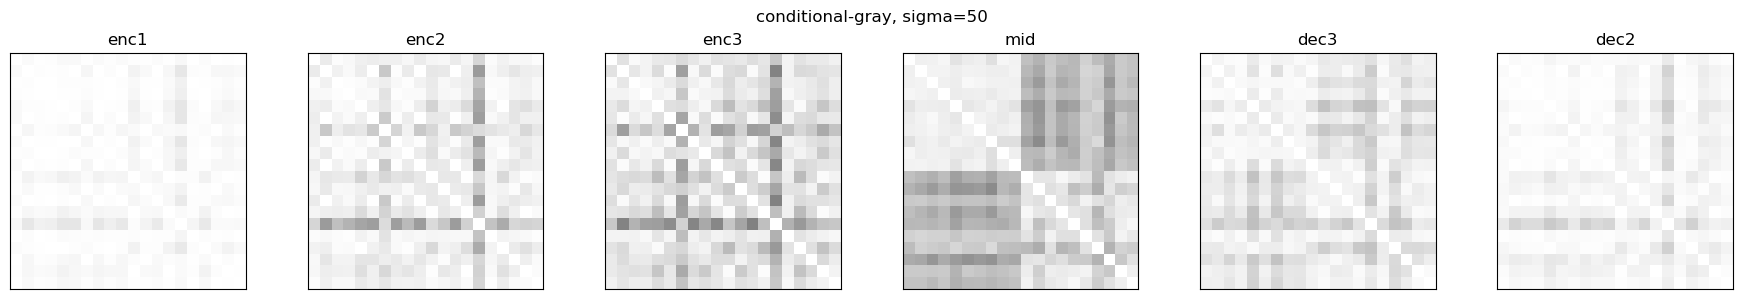

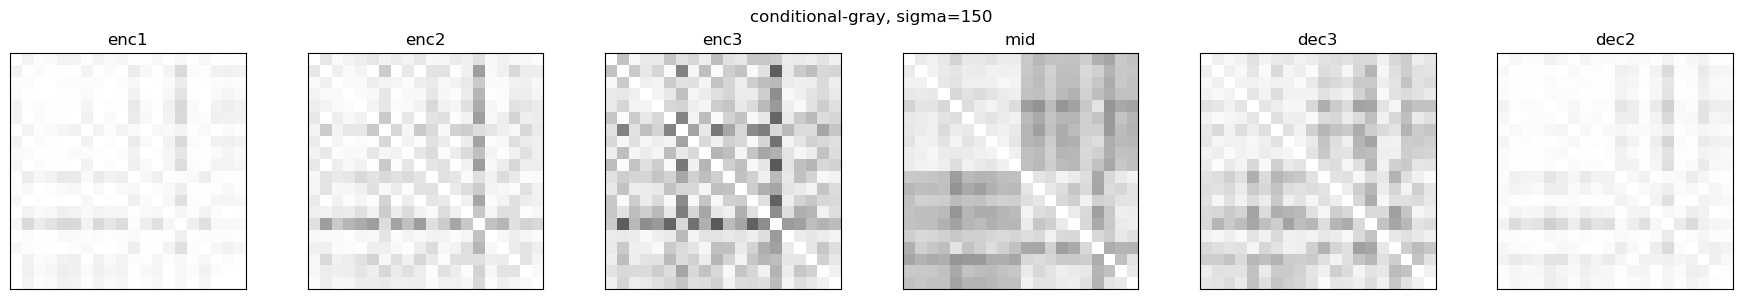

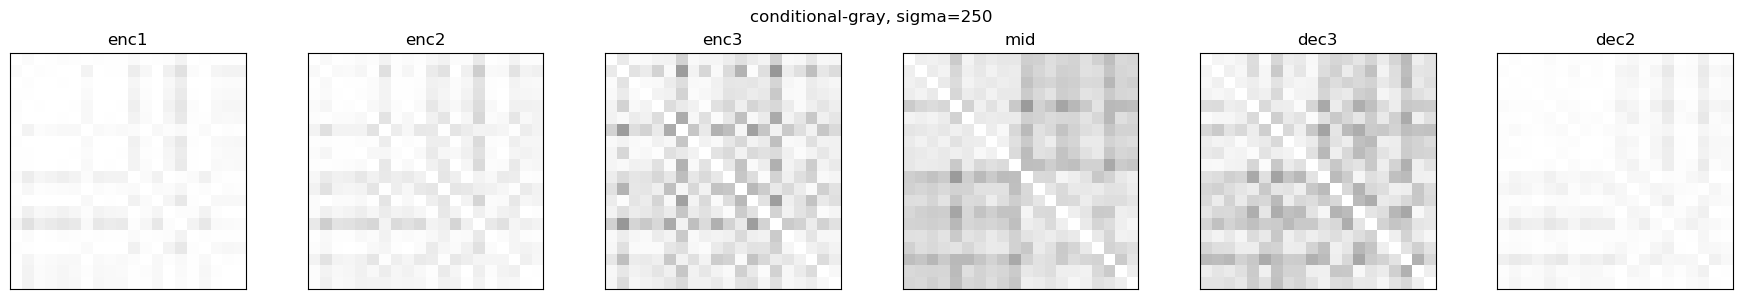

In [52]:
group = 'conditional-gray'
for sig in sigmas: 
    noisy_inp_ims = add_noise_torch(inp_ims.to(device), sig, device=device)[0]
    phi_xc, phi_x = get_channel_means(denoisers[group], x1=inp_ims, 
                              x2=noisy_inp_ims,
                              average_phi=False,with_params=True , return_activations=False)
        
    f, axs = plt.subplots(1, len(blocks), figsize = (18,3))
    plt.suptitle(group+ ', sigma='+str(sig))
    for block in range(len(blocks)): 
        axs[block].imshow(torch.abs(torch.corrcoef(phi_x[block].squeeze() )).cpu() , 'gray',vmin=0, vmax = 1)
        axs[block].tick_params(bottom=False,top = False, right = False, left=False)
        axs[block].set_xticks([])  
        axs[block].set_yticks([])      
        axs[block].set_title(blocks[block] )
    plt.tight_layout()


### change in pairwise correlation as a function of noise for more than two classes:

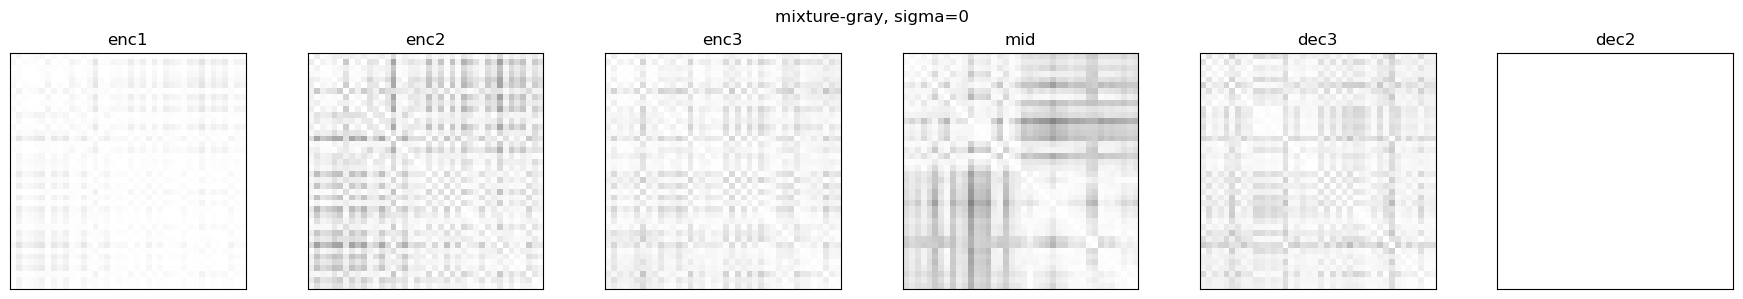

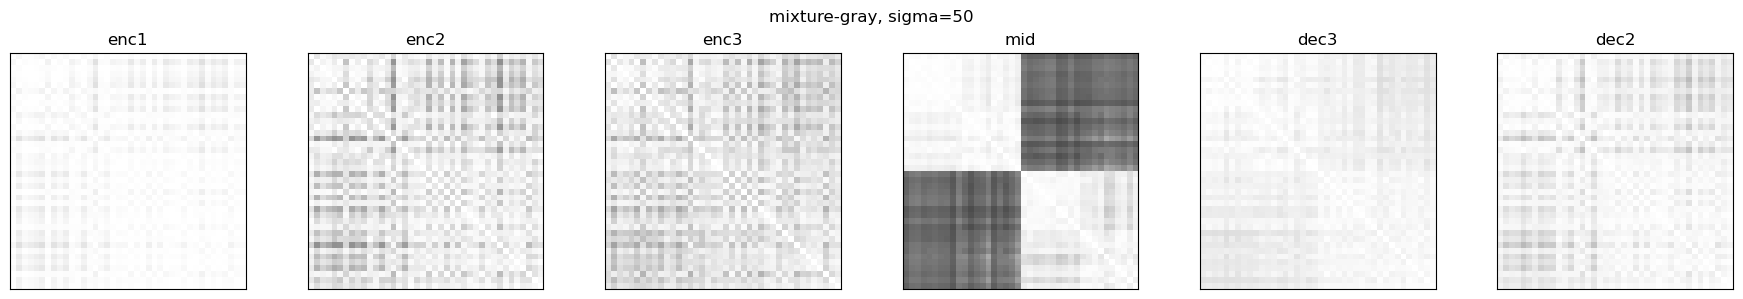

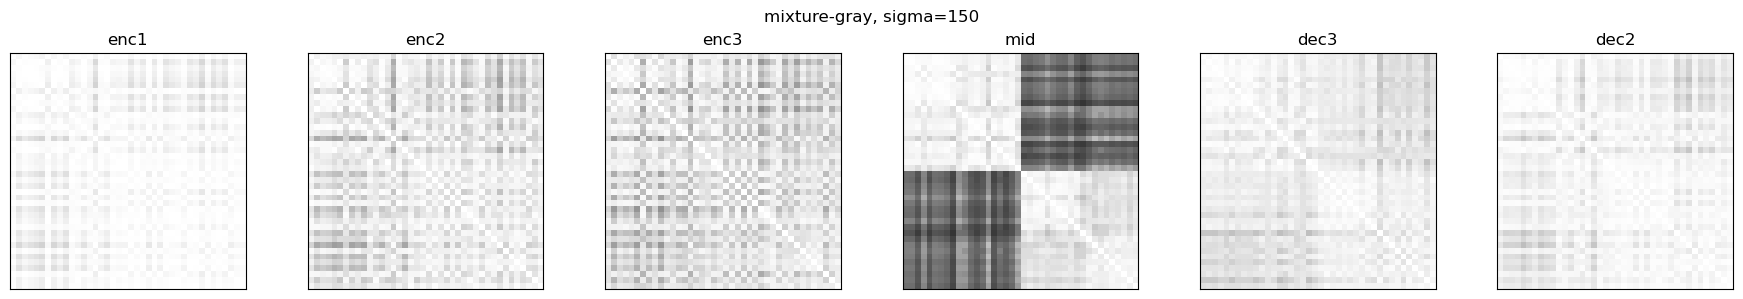

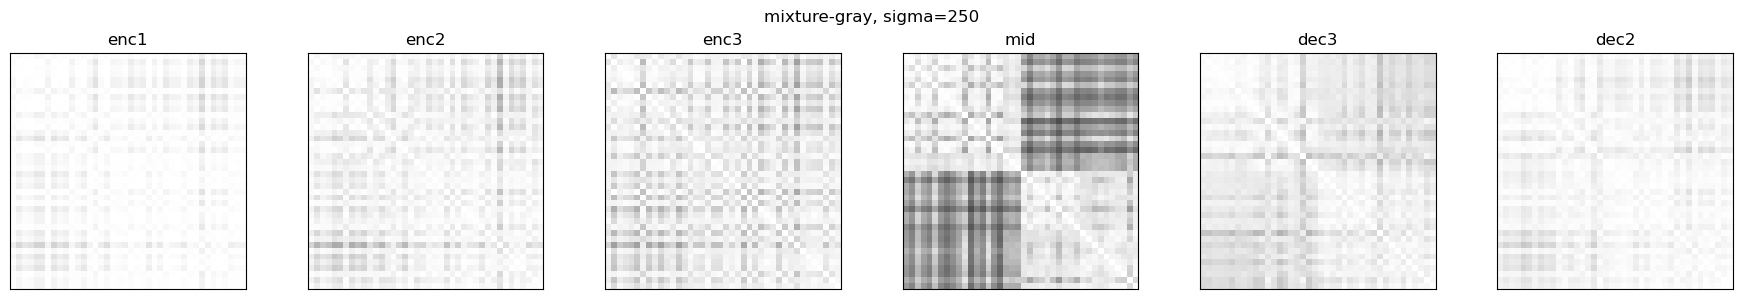

In [53]:
### average response per channel for different images from different classes (instead of pairwise response, we look at responses of many more classes )
ids = range(len(train_sets))

inp_ims = torch.cat([train_sets[category][0:10] for category in ids ])


group = 'mixture-gray'
if 'gray' in group.split('-'): 
    inp_ims = inp_ims.mean(dim = 1, keepdim = True)
sigmas= [0, 50,150,250]
for sig in sigmas: 
    noisy_inp_ims = add_noise_torch(inp_ims.to(device), sig, device=device)[0]
    phi_xc = get_channel_means(denoisers[group], x1=noisy_inp_ims, x2=None,
                              average_phi=False,with_params=True , return_activations=False)
        
    f, axs = plt.subplots(1, len(blocks), figsize = (18,3))
    plt.suptitle(group+ ', sigma='+str(sig))
    for block in range(len(blocks)): 
        axs[block].imshow(torch.abs(torch.corrcoef(phi_xc[block].squeeze() )).cpu() , 'gray',vmin=0, vmax = 1)
        axs[block].tick_params(bottom=False,top = False, right = False, left=False)
        axs[block].set_xticks([])  
        axs[block].set_yticks([])      
        axs[block].set_title(blocks[block] )
    plt.tight_layout()




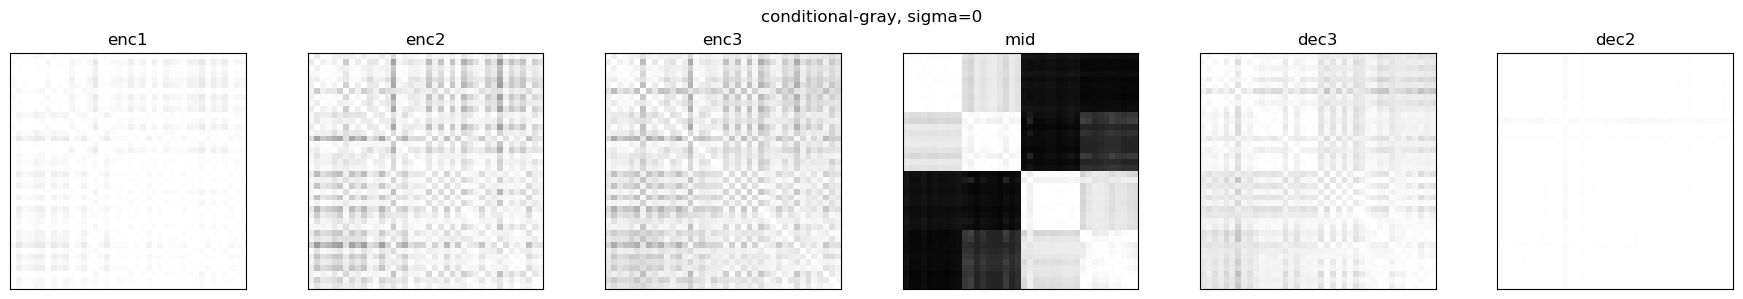

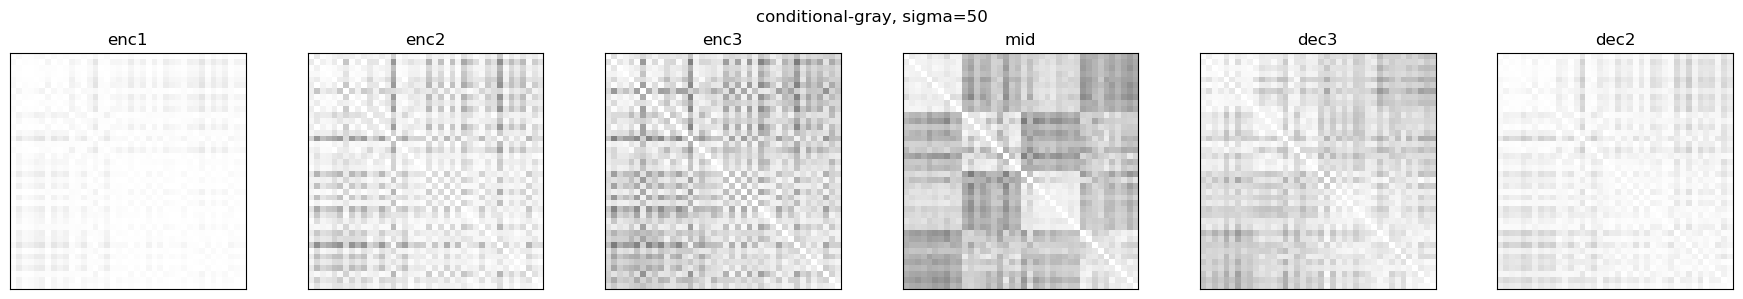

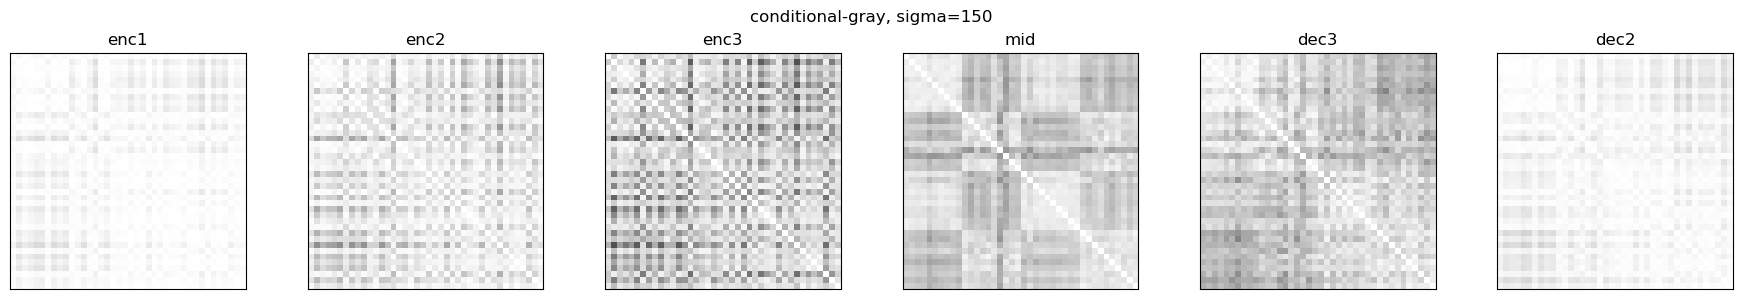

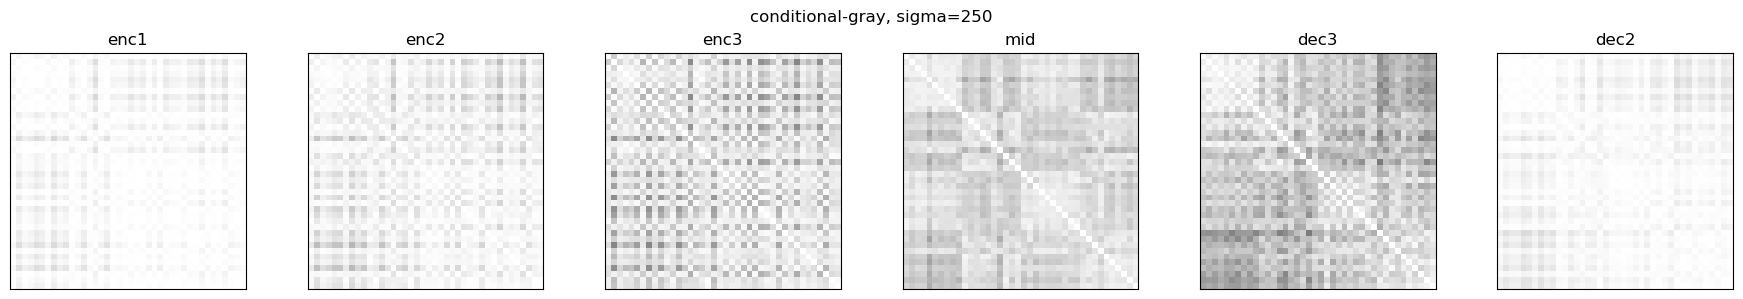

In [55]:
group = 'conditional-gray'
for sig in sigmas: 
    noisy_inp_ims = add_noise_torch(inp_ims.to(device), sig, device=device)[0]
    phi_xc, phi_x = get_channel_means(denoisers[group], x1=inp_ims, 
                              x2=noisy_inp_ims,
                              average_phi=False,with_params=True , return_activations=False)
        
    f, axs = plt.subplots(1, len(blocks), figsize = (18,3))
    plt.suptitle(group+ ', sigma='+str(sig))
    for block in range(len(blocks)): 
        axs[block].imshow(torch.abs(torch.corrcoef(phi_x[block].squeeze() )).cpu() , 'gray',vmin=0, vmax = 1)
        axs[block].tick_params(bottom=False,top = False, right = False, left=False)
        axs[block].set_xticks([])  
        axs[block].set_yticks([])      
        axs[block].set_title(blocks[block] )
    plt.tight_layout()


### least correlated images as a function of noise level per block:

Most decorrelated images at different noise levelsaccoring to block:  mid


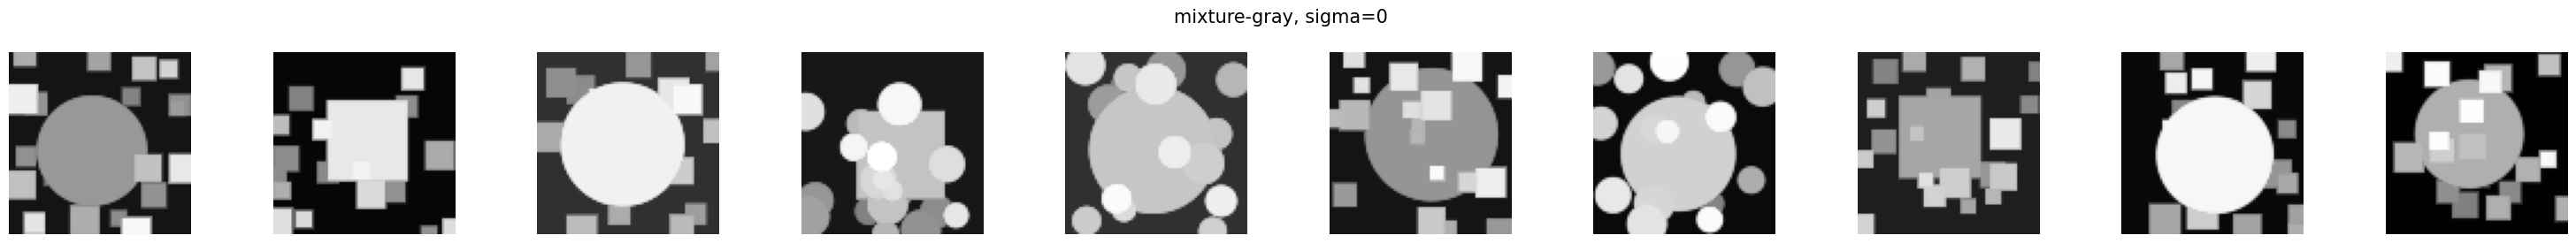

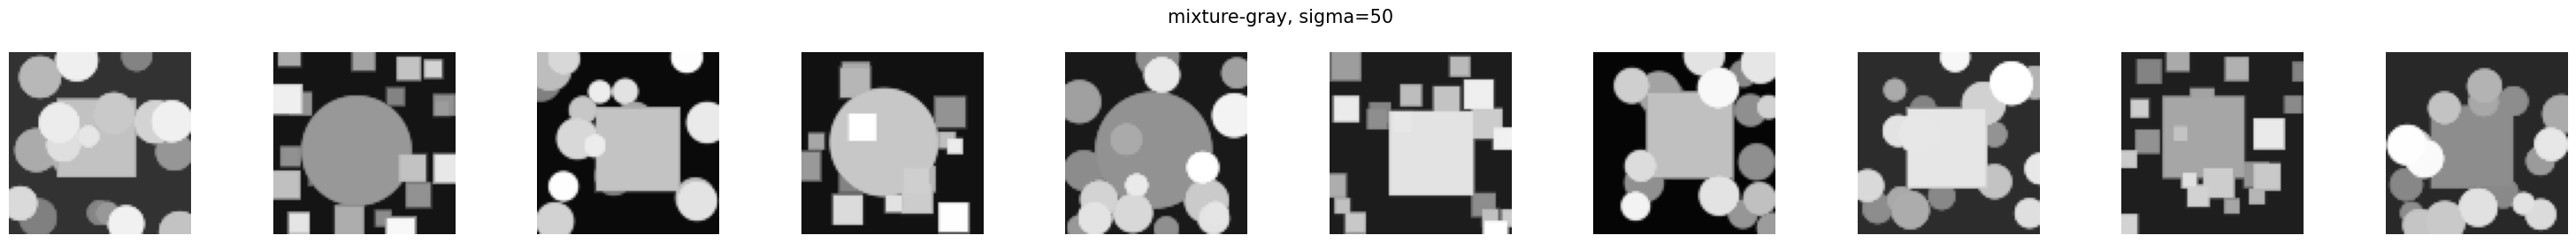

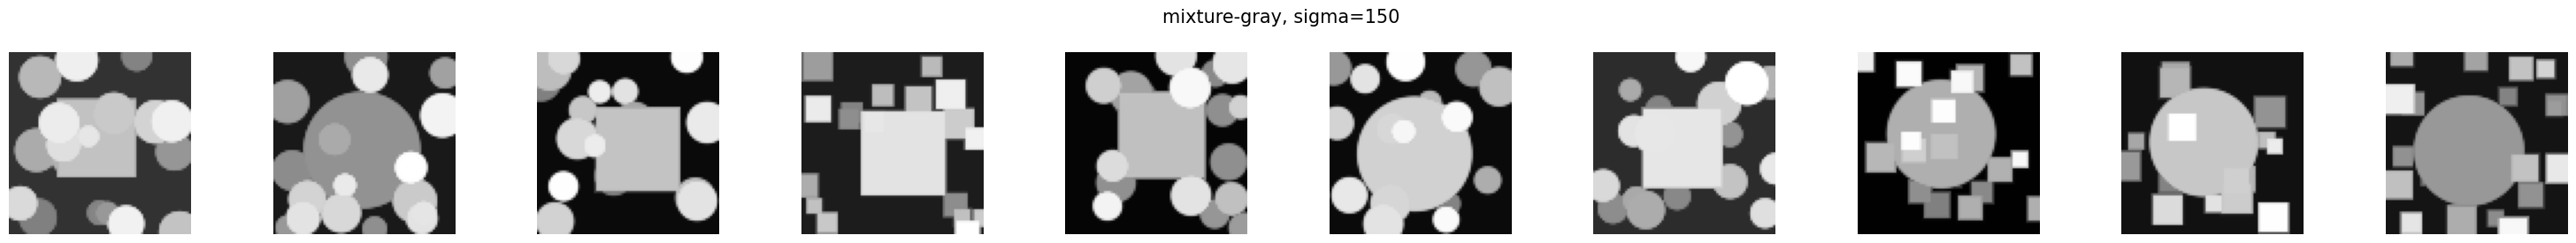

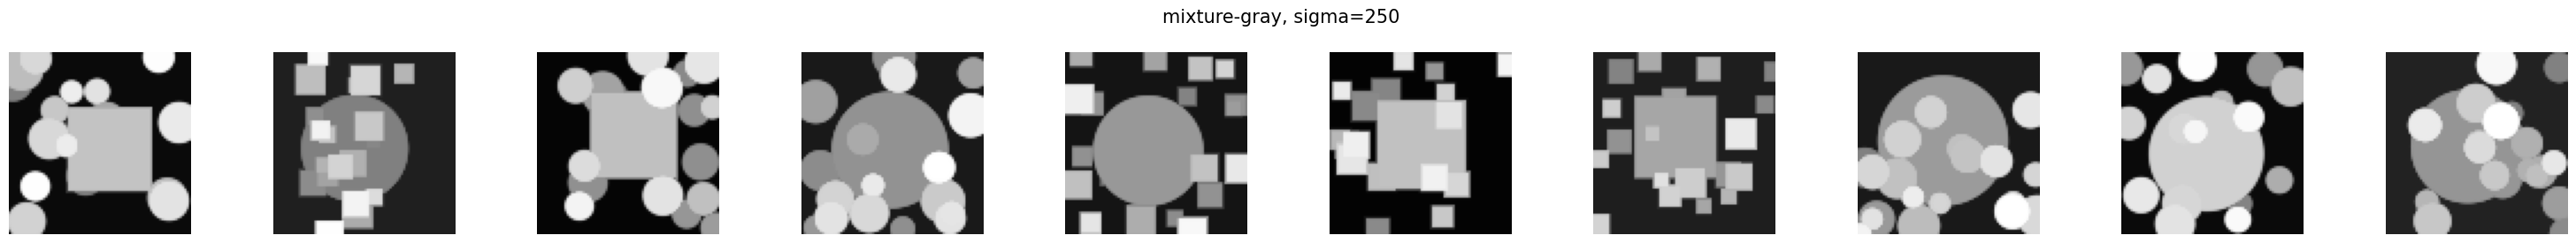

In [56]:
block = 3
###################
ids = range(len(train_sets))

inp_ims = torch.cat([train_sets[category][0:10] for category in ids ])

group = 'mixture-gray'
if 'gray' in group.split('-'): 
    inp_ims = inp_ims.mean(dim = 1, keepdim = True)

print('Most decorrelated images at different noise levelsaccoring to block: ' , blocks[block])
for sig in sigmas:
    phi_xc = get_channel_means(denoisers[group], 
                      add_noise_torch(inp_ims.to(device), sig, device=device)[0],
                      average_phi=False,with_params=True, return_activations=False)
    
    cov = torch.corrcoef(phi_xc[block].squeeze() ).cpu()          
    idx = cov.sum(dim = 0).sort()[1]
    show_im_set(inp_ims[idx][0:10], n_columns=10, 
                sub_labels= ['']* inp_ims.shape[0] , 
                label= group + ', sigma='+ str(sig), 
                vmin=0,  vmax = 1) 


Most decorrelated images at different noise levels accoring to block:  dec3


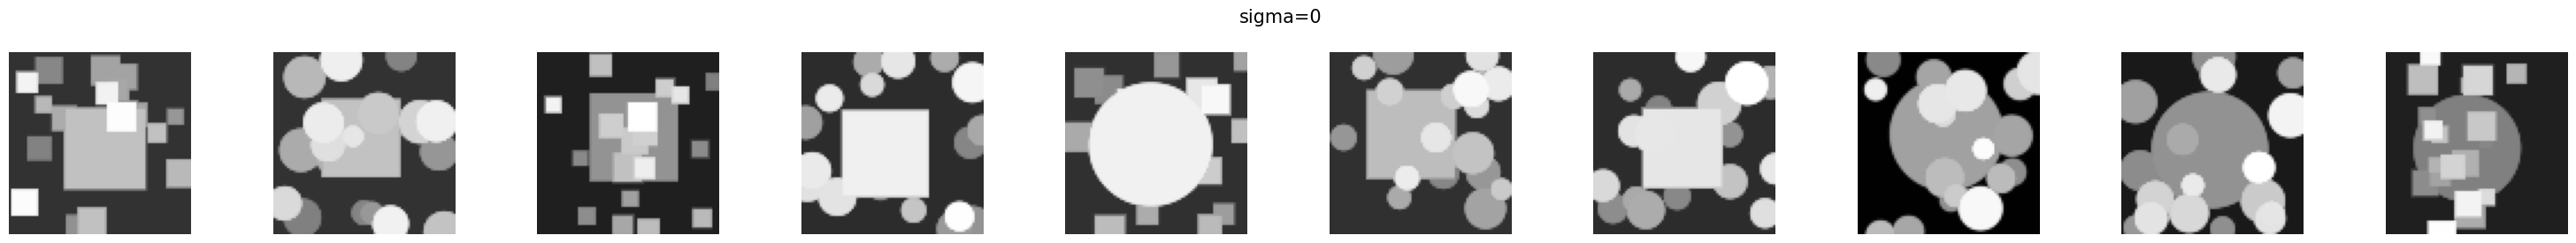

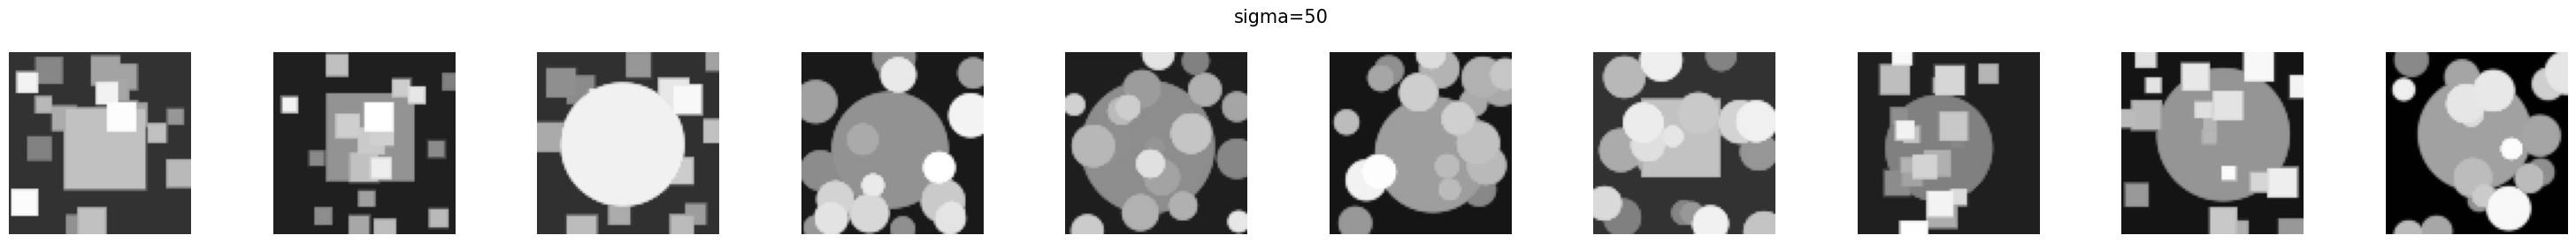

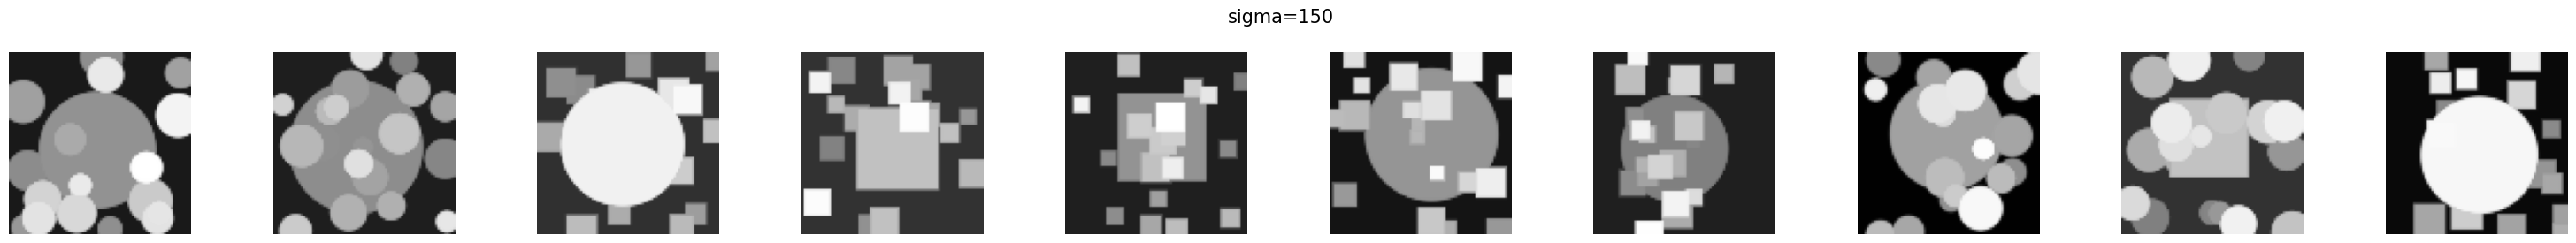

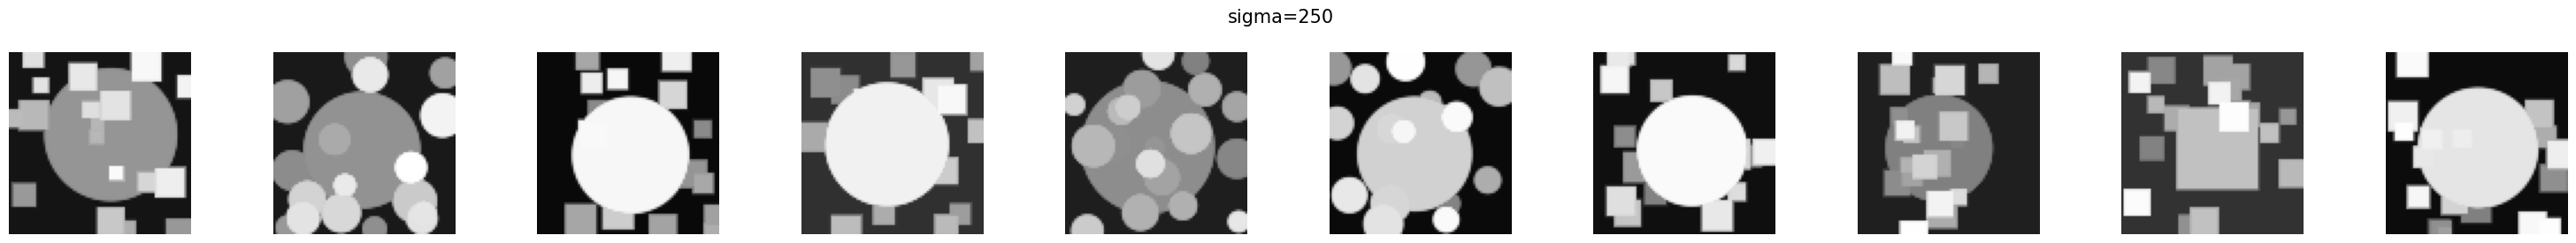

In [57]:
group = 'conditional-gray'
if 'gray' in group.split('-'): 
    inp_ims = inp_ims.mean(dim = 1, keepdim = True)
block = 4

print('Most decorrelated images at different noise levels accoring to block: ' , blocks[block])
for sig in sigmas:
    phi_xc,phi_x = get_channel_means(denoisers[group], x1= inp_ims,
                      x2=add_noise_torch(inp_ims.to(device), sig, device=device)[0],                      
                      average_phi=False,with_params=True, return_activations=False)
    
    cov = torch.corrcoef(phi_x[block].squeeze() ).cpu()       
    idx = cov.sum(dim = 0).sort()[1]
    show_im_set(inp_ims[idx][0:10], n_columns=10, sub_labels= ['']* inp_ims.shape[0] , 
                label='sigma='+ str(sig), vmin=0,  vmax = 1)


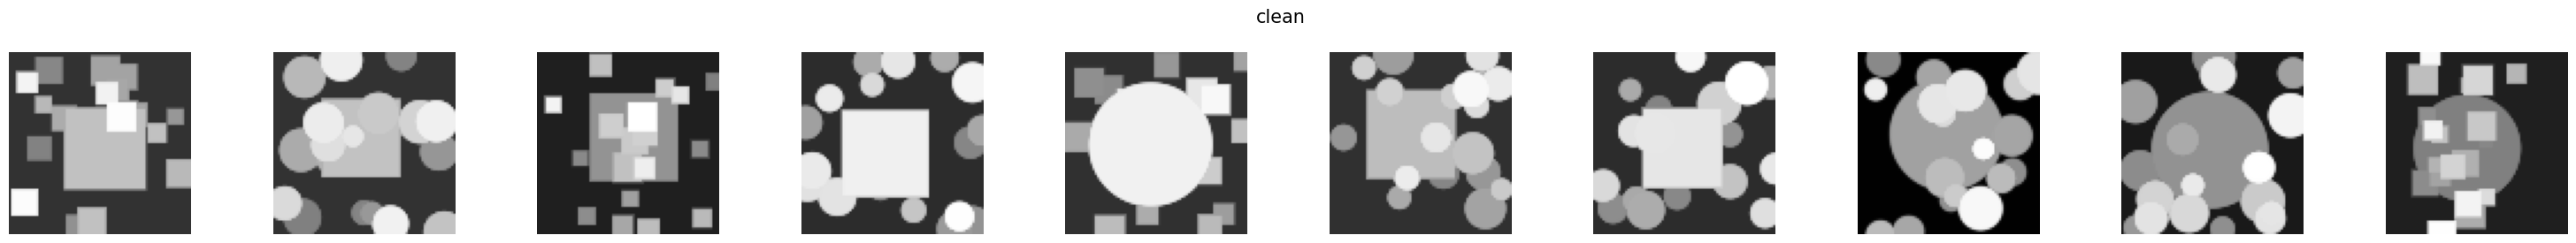

In [58]:
cov = torch.corrcoef(phi_xc[block].squeeze() ).cpu()       
idx = cov.sum(dim = 0).sort()[1]
show_im_set(inp_ims[idx][0:10], n_columns=10, sub_labels= ['']* inp_ims.shape[0] , label='clean',vmin=0,  vmax = 1) 

Most decorrelated images across different blocks at noise level:  250


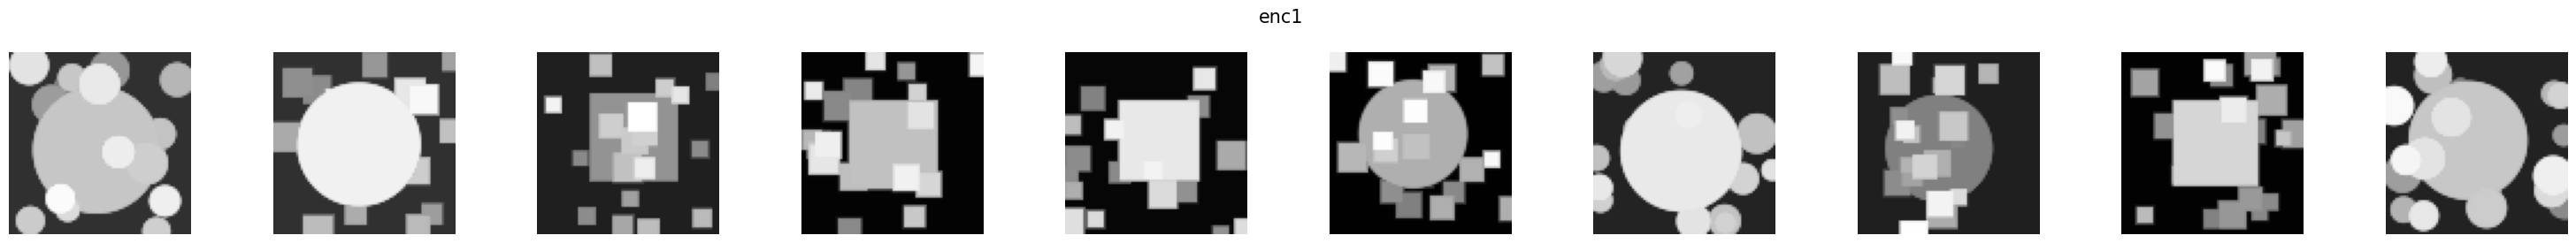

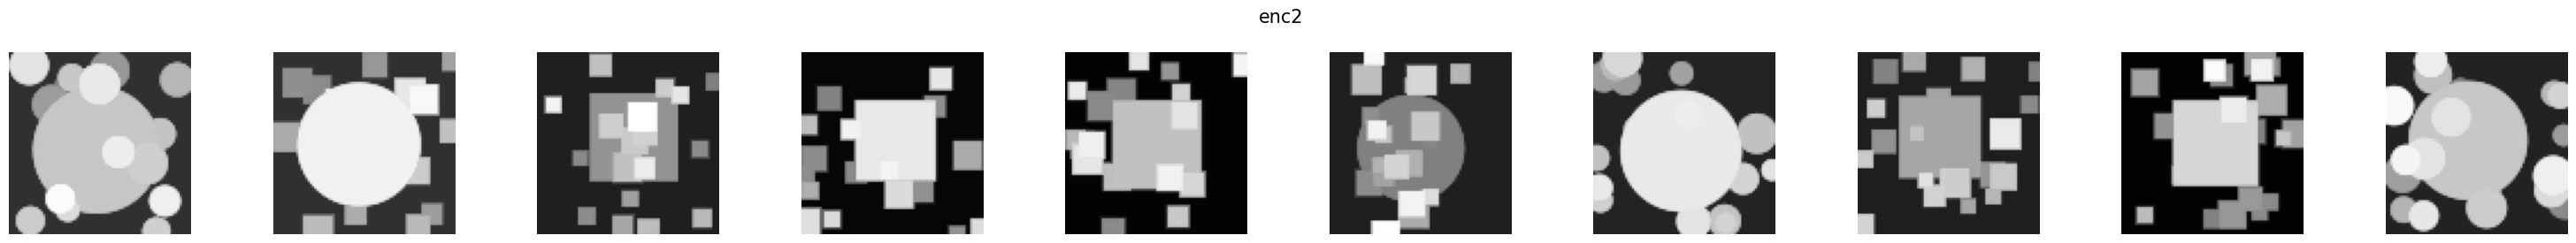

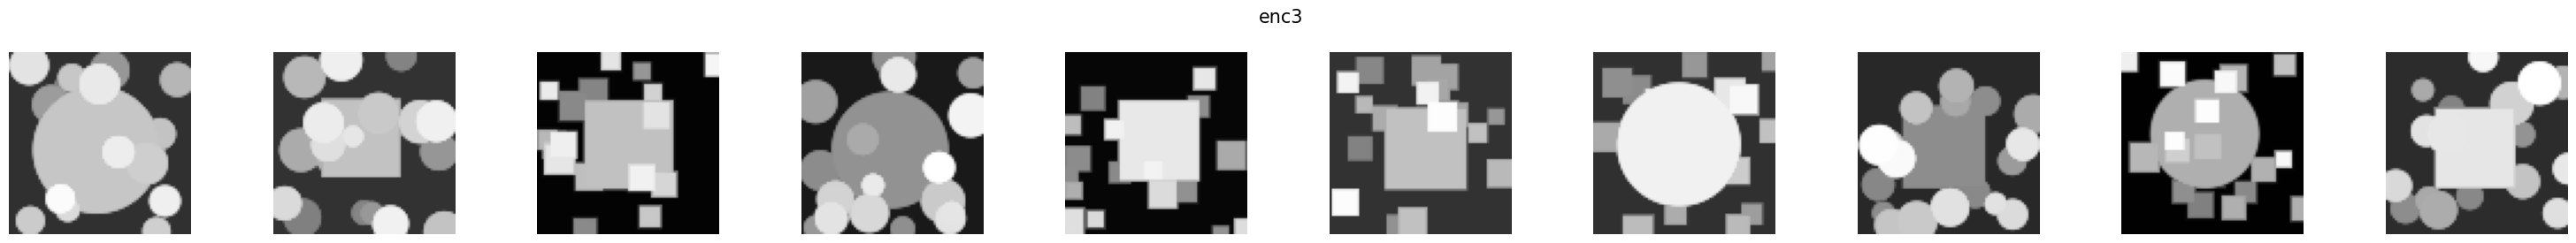

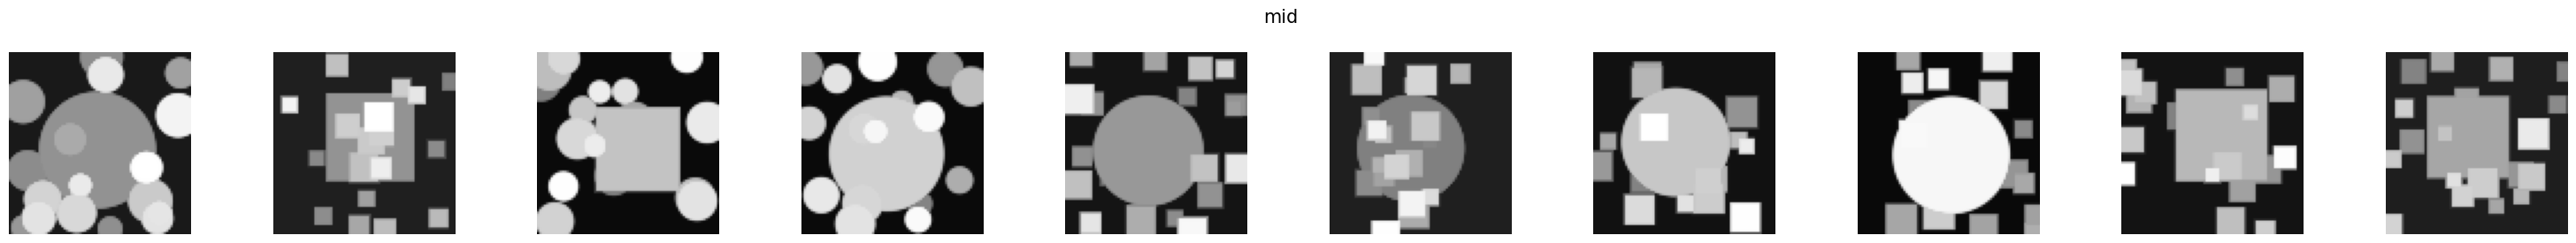

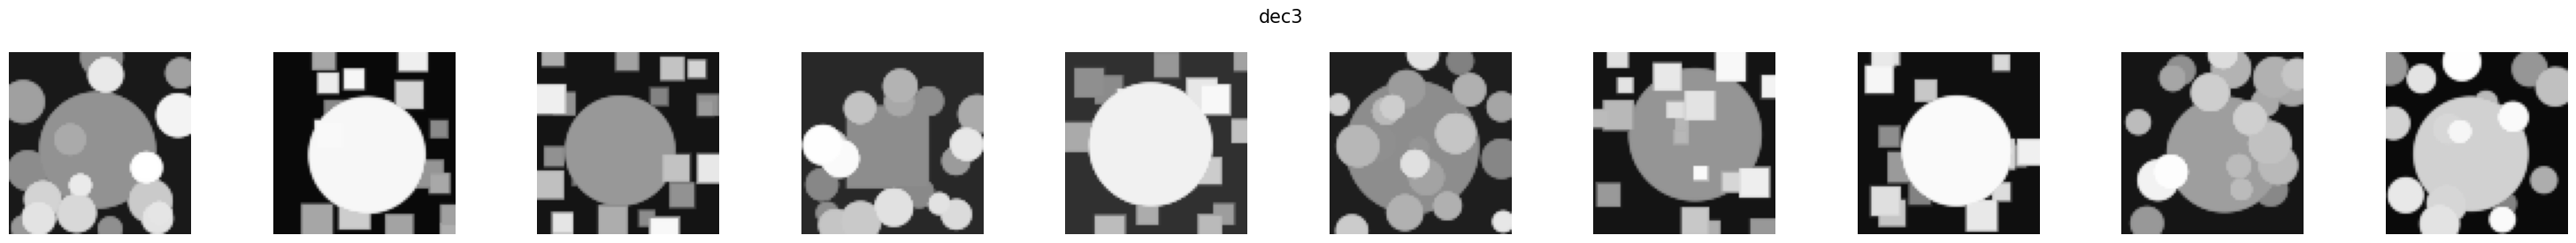

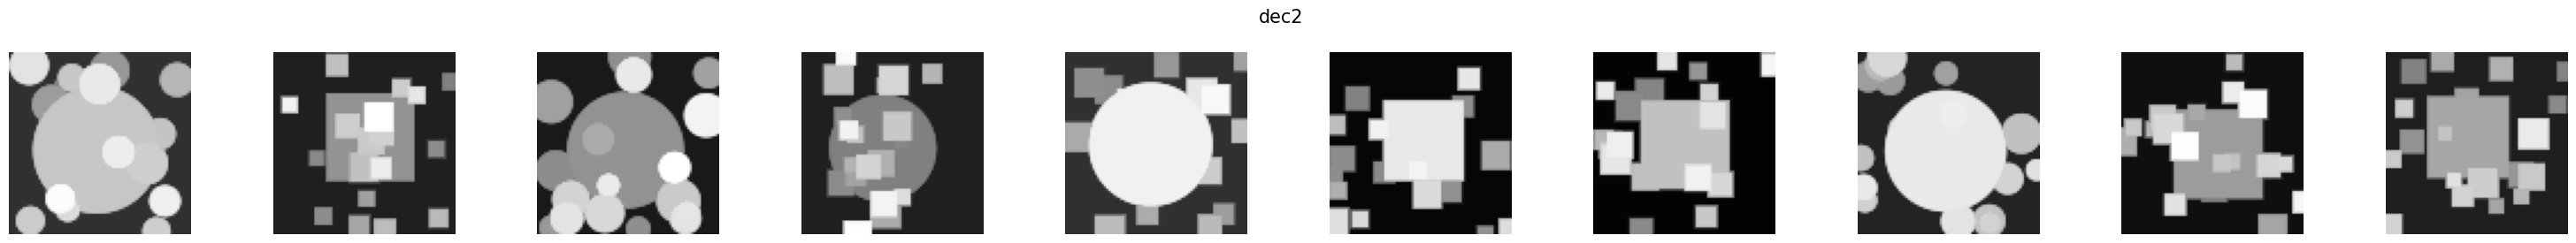

In [59]:
sig = 250
group = 'mixture-gray'
phi_xc = get_channel_means(denoisers[group], 
                      add_noise_torch(inp_ims.to(device), sig, device=device)[0],
                      average_phi=False,with_params=True, return_activations=False)


print('Most decorrelated images across different blocks at noise level: ' , sig)

for block in range(len(blocks)):
    cov = torch.corrcoef(phi_xc[block].squeeze() ).cpu()       
    idx = cov.sum(dim = 0).sort()[1]
    show_im_set(inp_ims[idx][0:10], n_columns=10, sub_labels= ['']* inp_ims.shape[0], 
                label=blocks[block],vmin=0,  vmax = 1 ) 

Most decorrelated images across different blocks for sigma 250


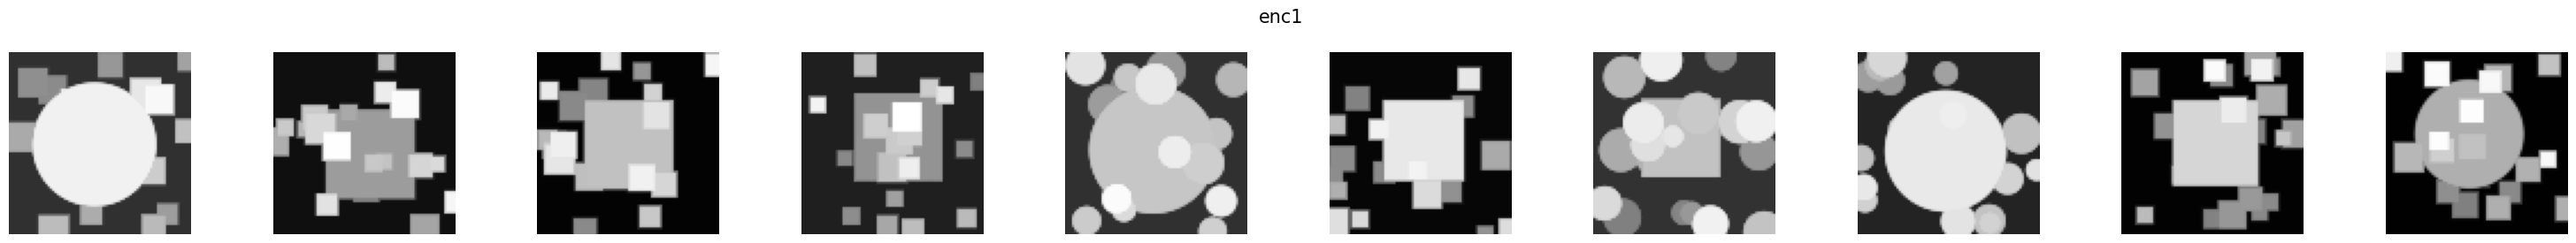

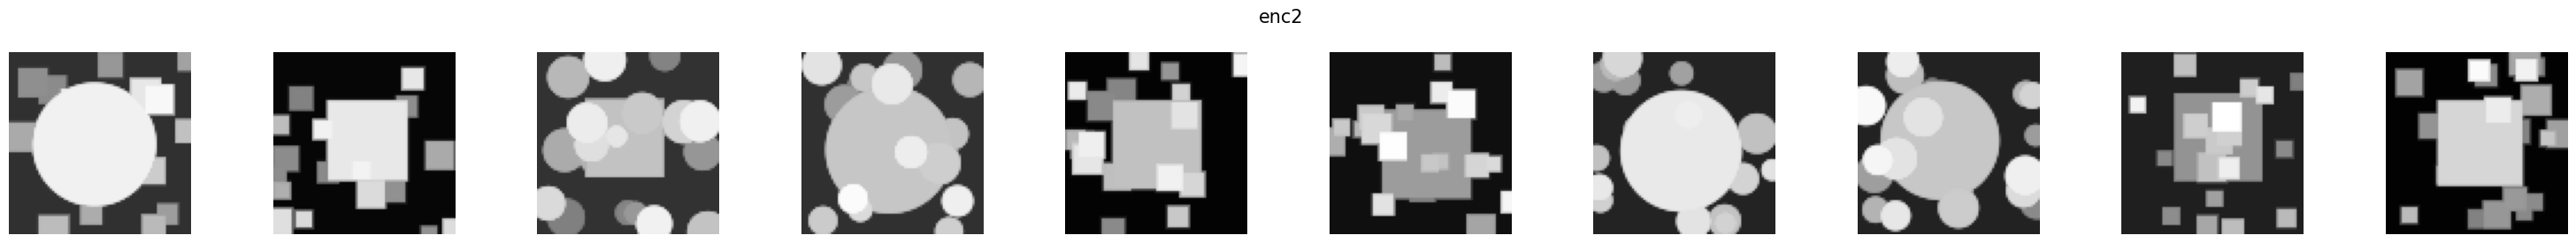

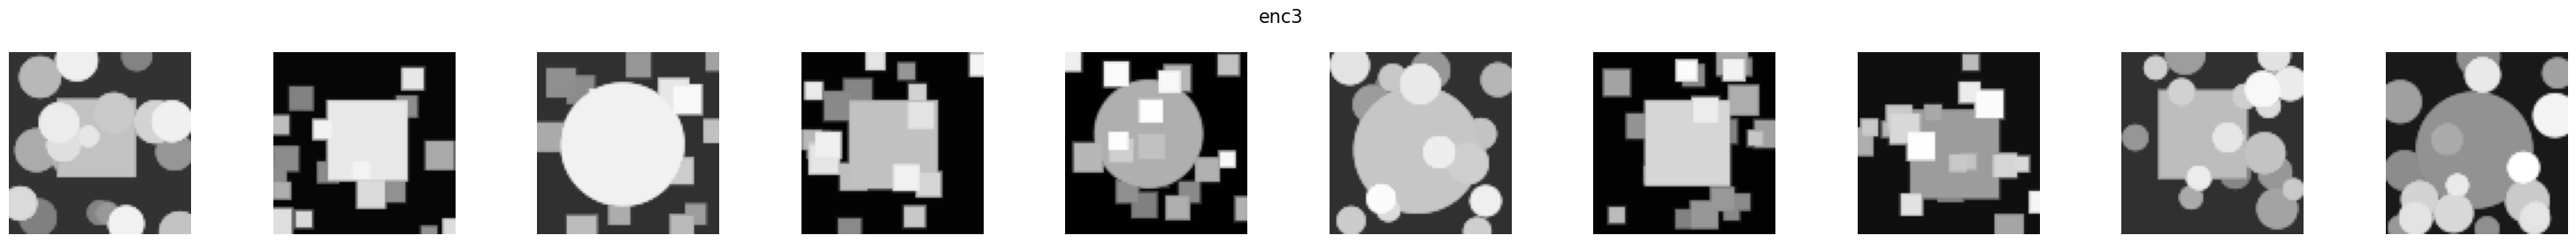

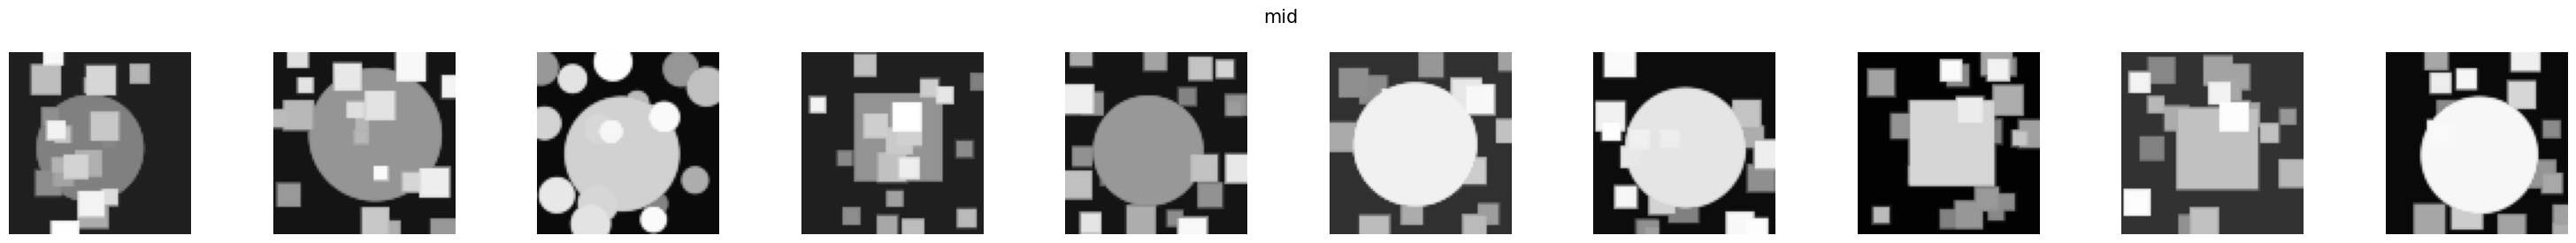

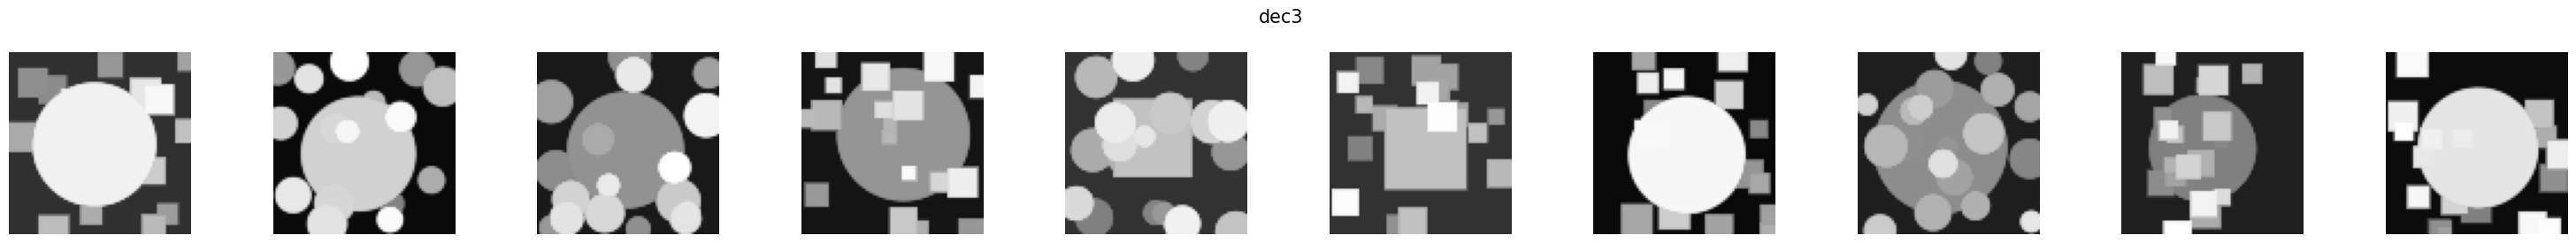

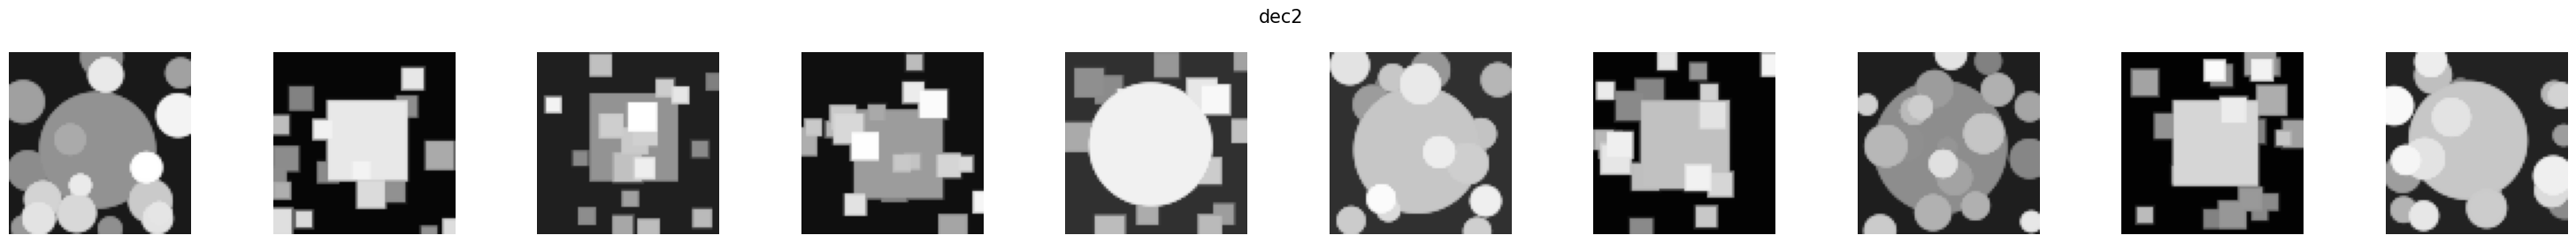

In [60]:
group = 'conditional-gray'
sig=250
phi_xc,phi_x = get_channel_means(denoisers[group], x1= inp_ims,
                      x2=add_noise_torch(inp_ims.to(device), sig, device=device)[0],                      
                      average_phi=False,with_params=True, return_activations=False)

print('Most decorrelated images across different blocks for sigma' , sig)
for block in range(len(blocks)):
    cov = torch.corrcoef(phi_x[block].squeeze() ).cpu()       
    idx = cov.sum(dim = 0).sort()[1]
    show_im_set(inp_ims[idx][0:10], n_columns=10, sub_labels= ['']* inp_ims.shape[0] ,
                label=blocks[block], vmin=0,  vmax = 1) 

Most decorrelated images across different blocks for clean image


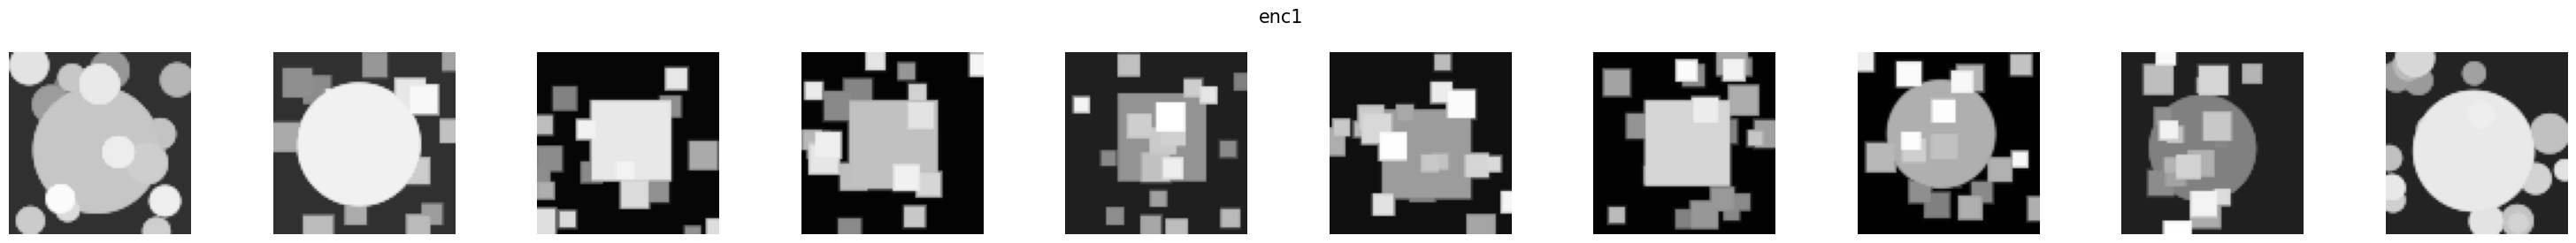

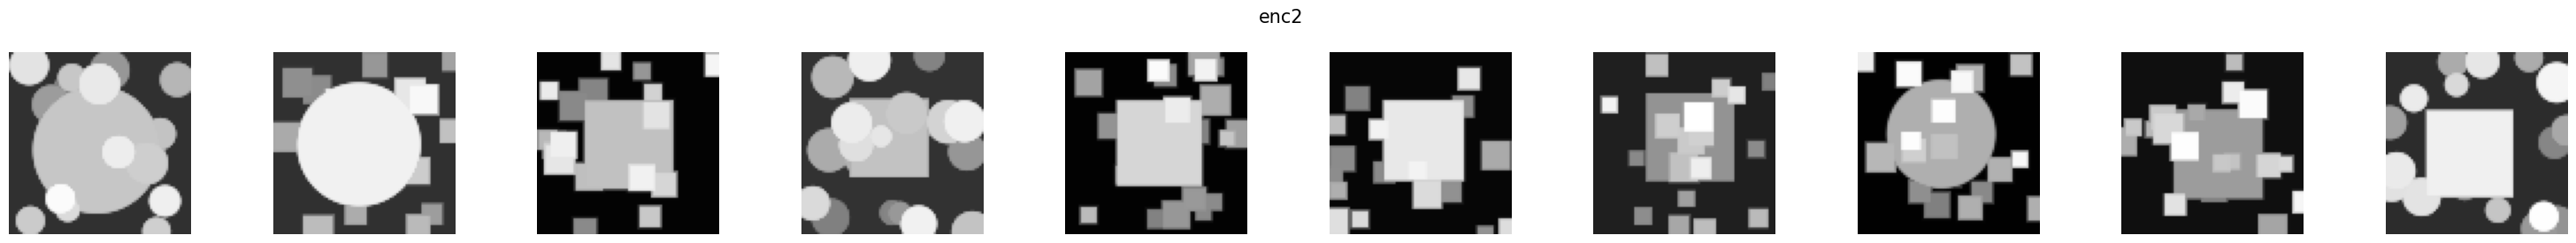

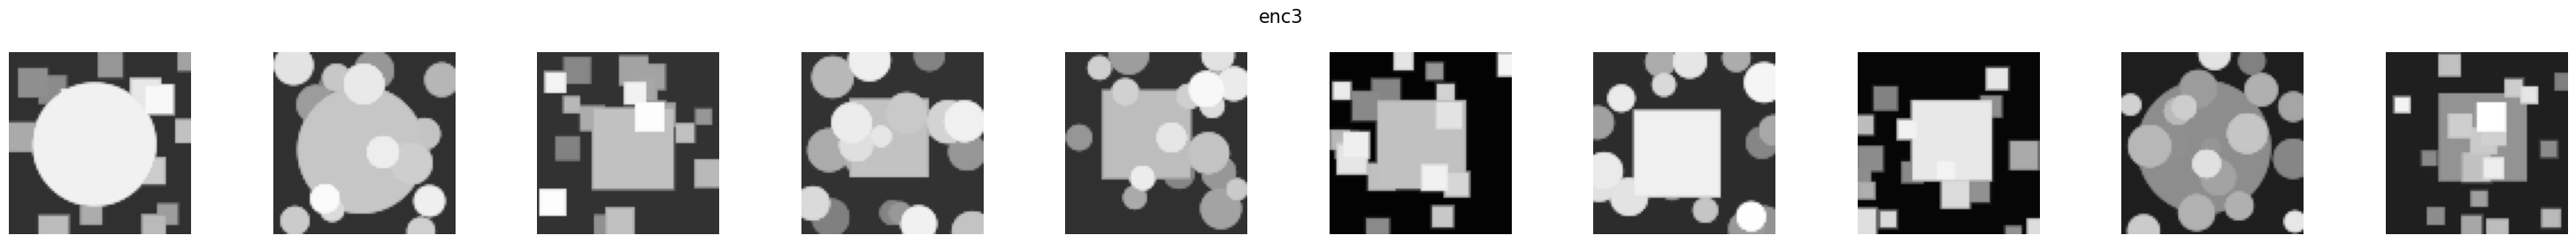

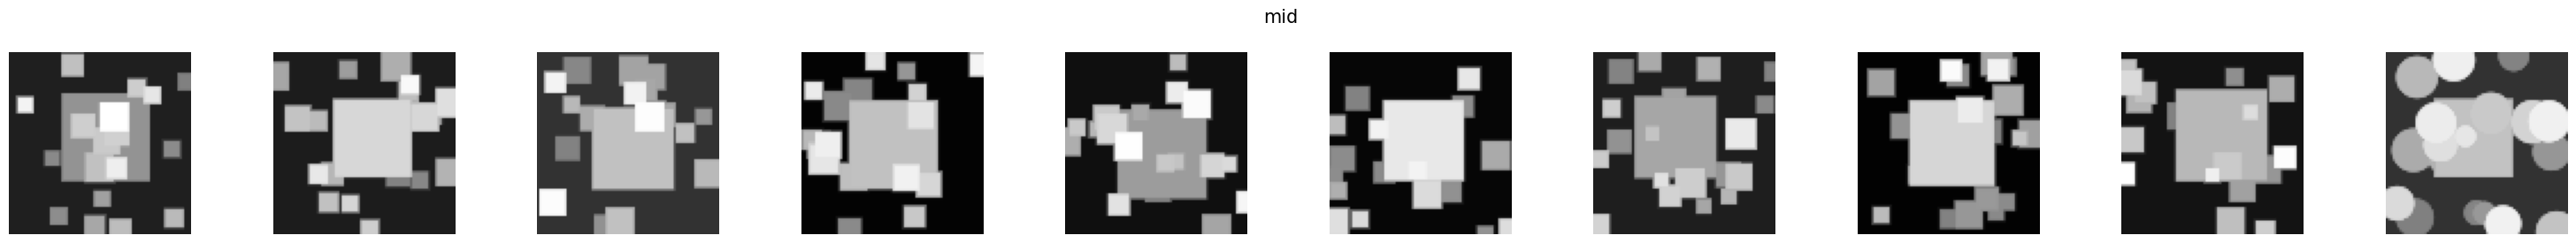

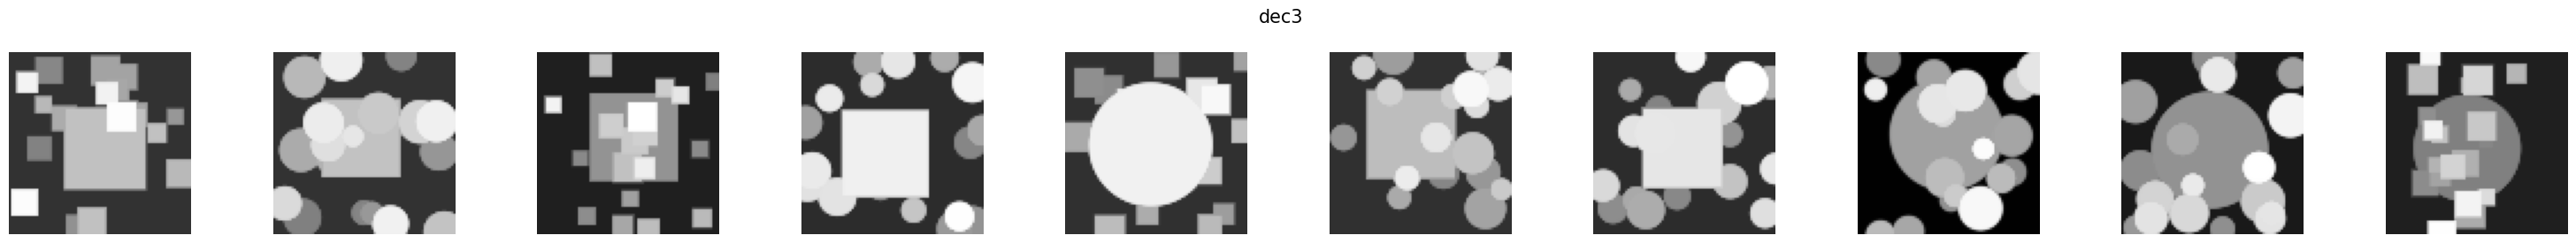

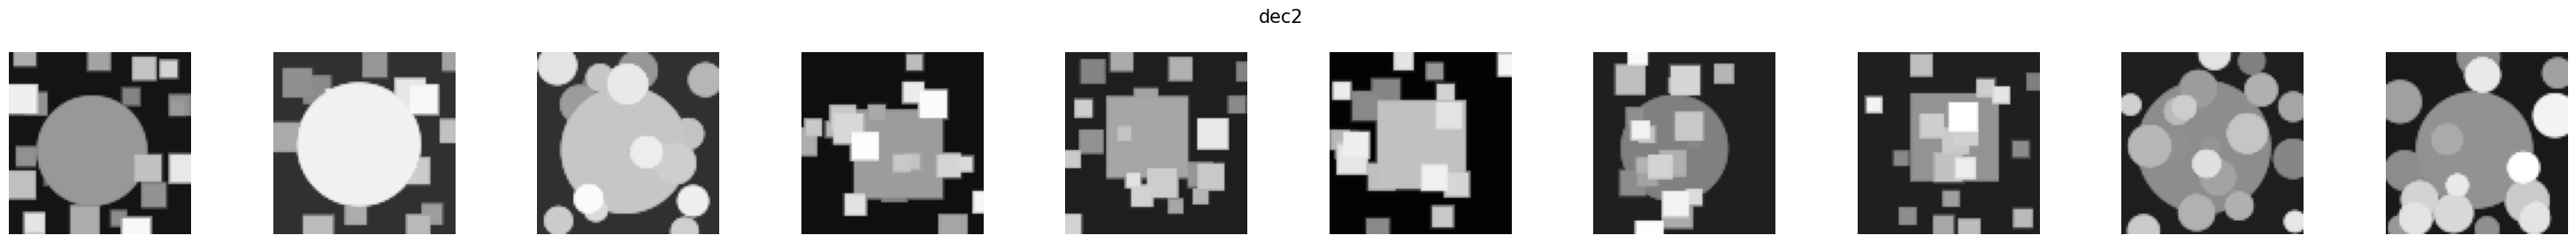

In [61]:
print('Most decorrelated images across different blocks for clean image')
for block in range(len(blocks)):
    cov = torch.corrcoef(phi_xc[block].squeeze() ).cpu()       
    idx = cov.sum(dim = 0).sort()[1]
    show_im_set(inp_ims[idx][0:10], n_columns=10, sub_labels= ['']* inp_ims.shape[0] ,
                label=blocks[block],vmin=0,  vmax = 1) 